In [108]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# plt styles
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 300

### Observation dates plot

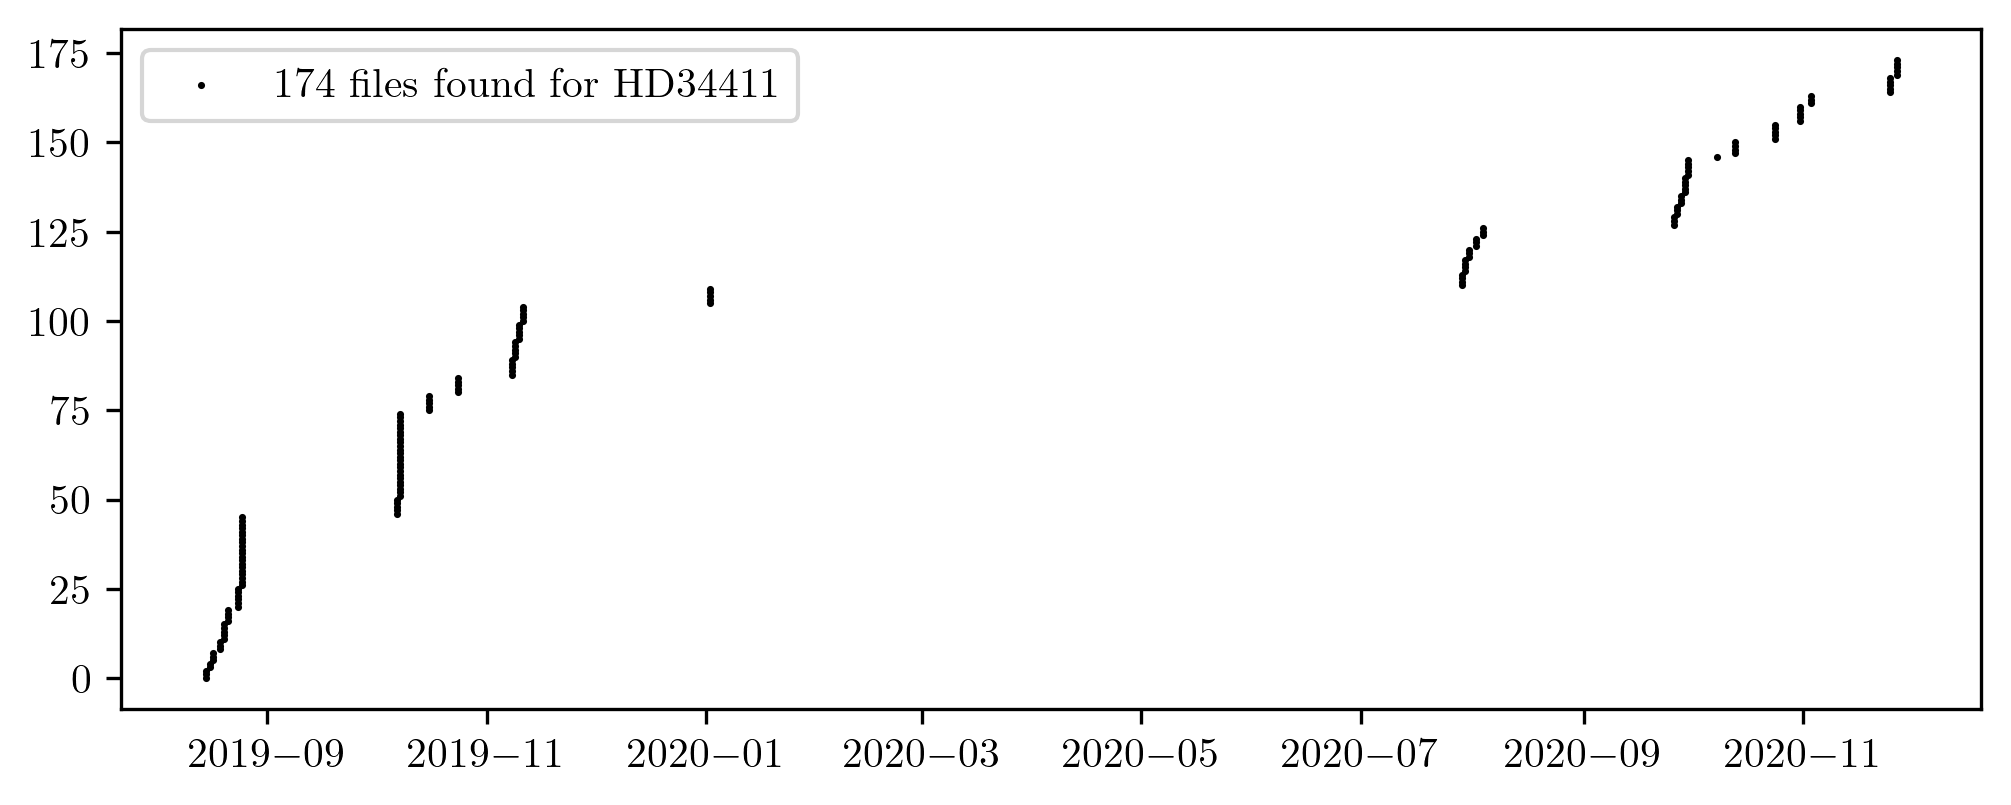

In [256]:
# filenames = get_all_spectra_filenames(SPECTRA_PATH_34411)
filenames = get_all_spectra_filenames(SPECTRA_PATH_10700)
dates = get_spectra_dates(filenames)

label=f"{len(dates)} files found for HD34411"
from datetime import datetime
plt.figure(figsize=(8, 3))
for index, date in enumerate(dates):
    year, month, date = date
    d = datetime(year, month, date)
    if label and index == len(dates) - 1:
        plt.scatter(d, index, color="k", s=0.5, label=label)
        plt.legend()
    else:
        plt.scatter(d, index, color="k", s=0.5)

# plt.savefig("dates_HD34411.pdf", bbox_inches="tight", dpi=300)

In [33]:
filenames = get_all_spectra_filenames(SPECTRA_PATH_101501)
dates = get_spectra_dates(filenames)
len(dates)

45

### Matrix and fit for non-bary-centric data to show earth movement and the usage of the matrix reduction

In [139]:
# filename = "lily_data_results/all_features_34411_ms_non_bary.npy"
filename = "lily_data_results/34411_all_baryFalse_err1_dist1_area01.npy"
result, coords = np.load(filename, allow_pickle=True)
diff_matrix, diff_matrix_err, diff_matrix_valid = parse_matrix_results(result, coords)
m, final_shifts, final_shifts_err, days = matrix_reduce(diff_matrix, diff_matrix_err, diff_matrix_valid, SPECTRA_PATH_34411, plot=False, with_date_duplicates=True)

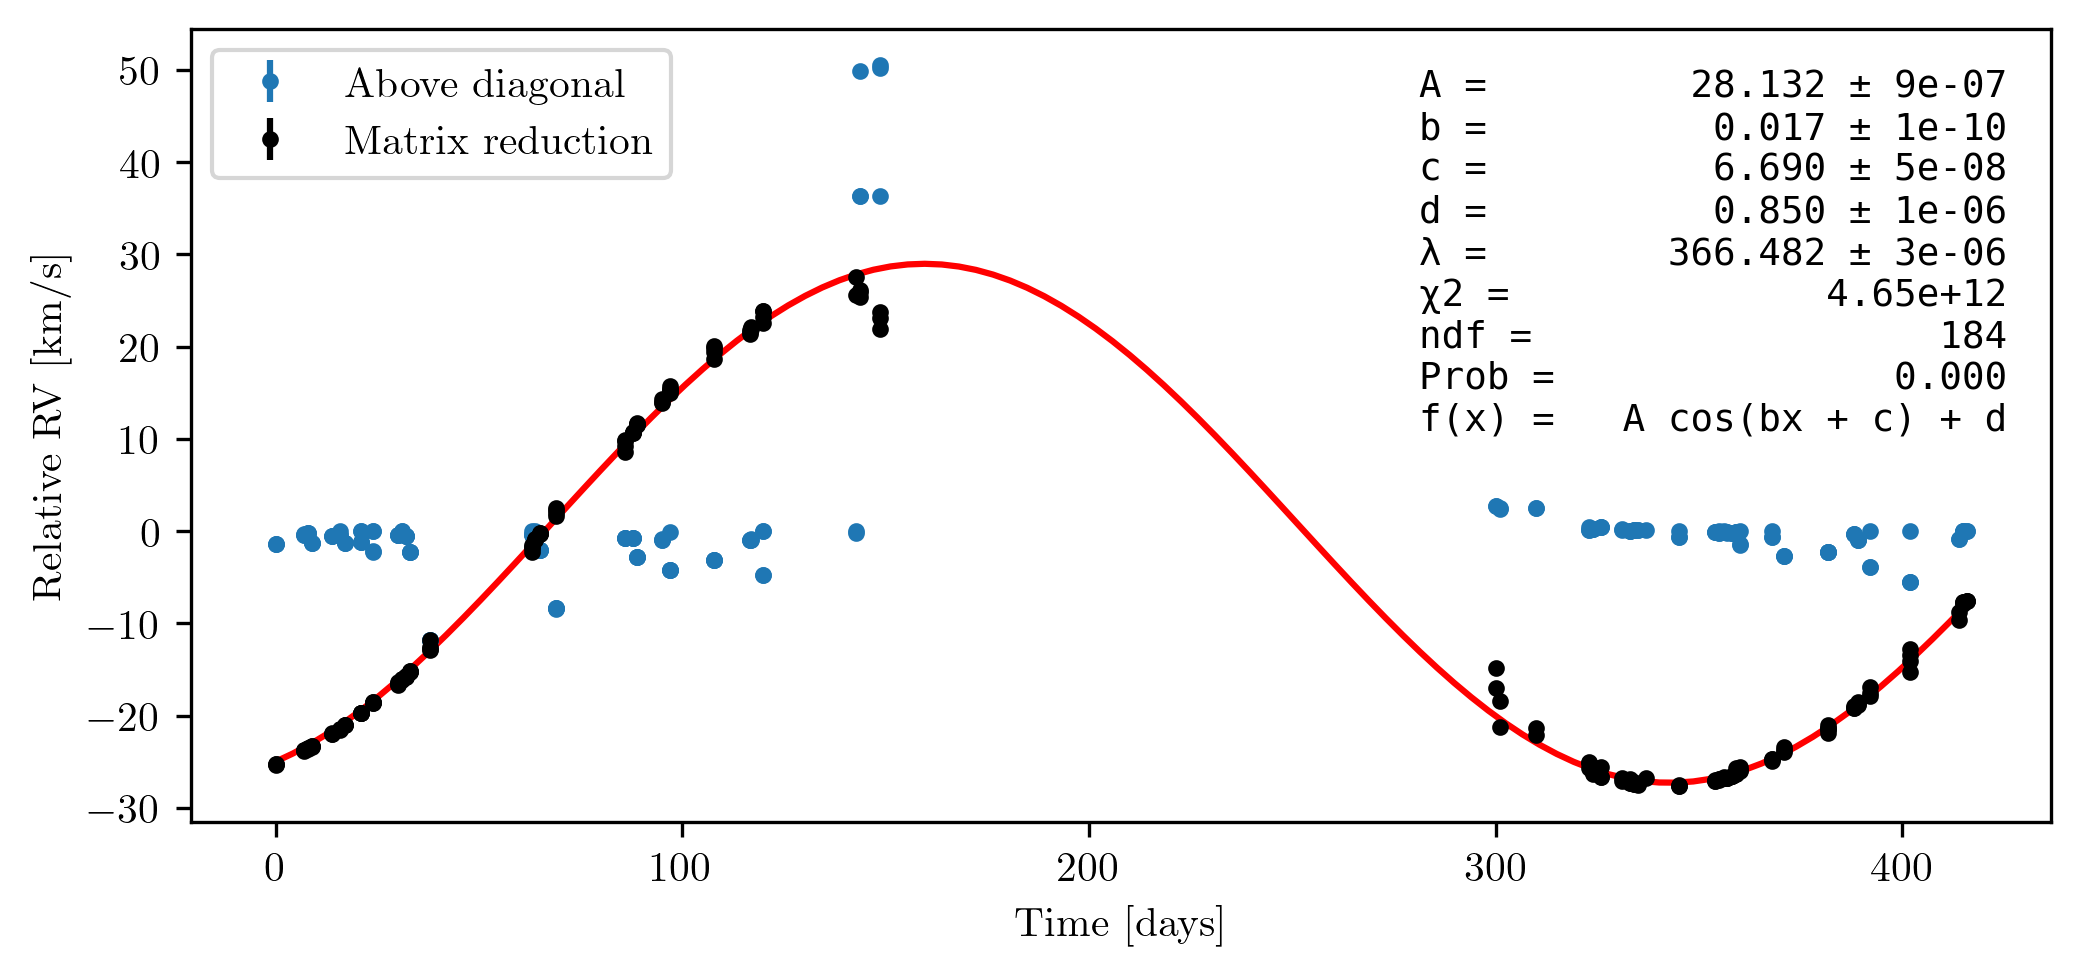

In [140]:
fit_final_shifts(final_shifts, final_shifts_err, diff_matrix, diff_matrix_err, with_date_duplicates=True,
    # save_as="latex/figures/shift_non_bary_centric.pdf"
)


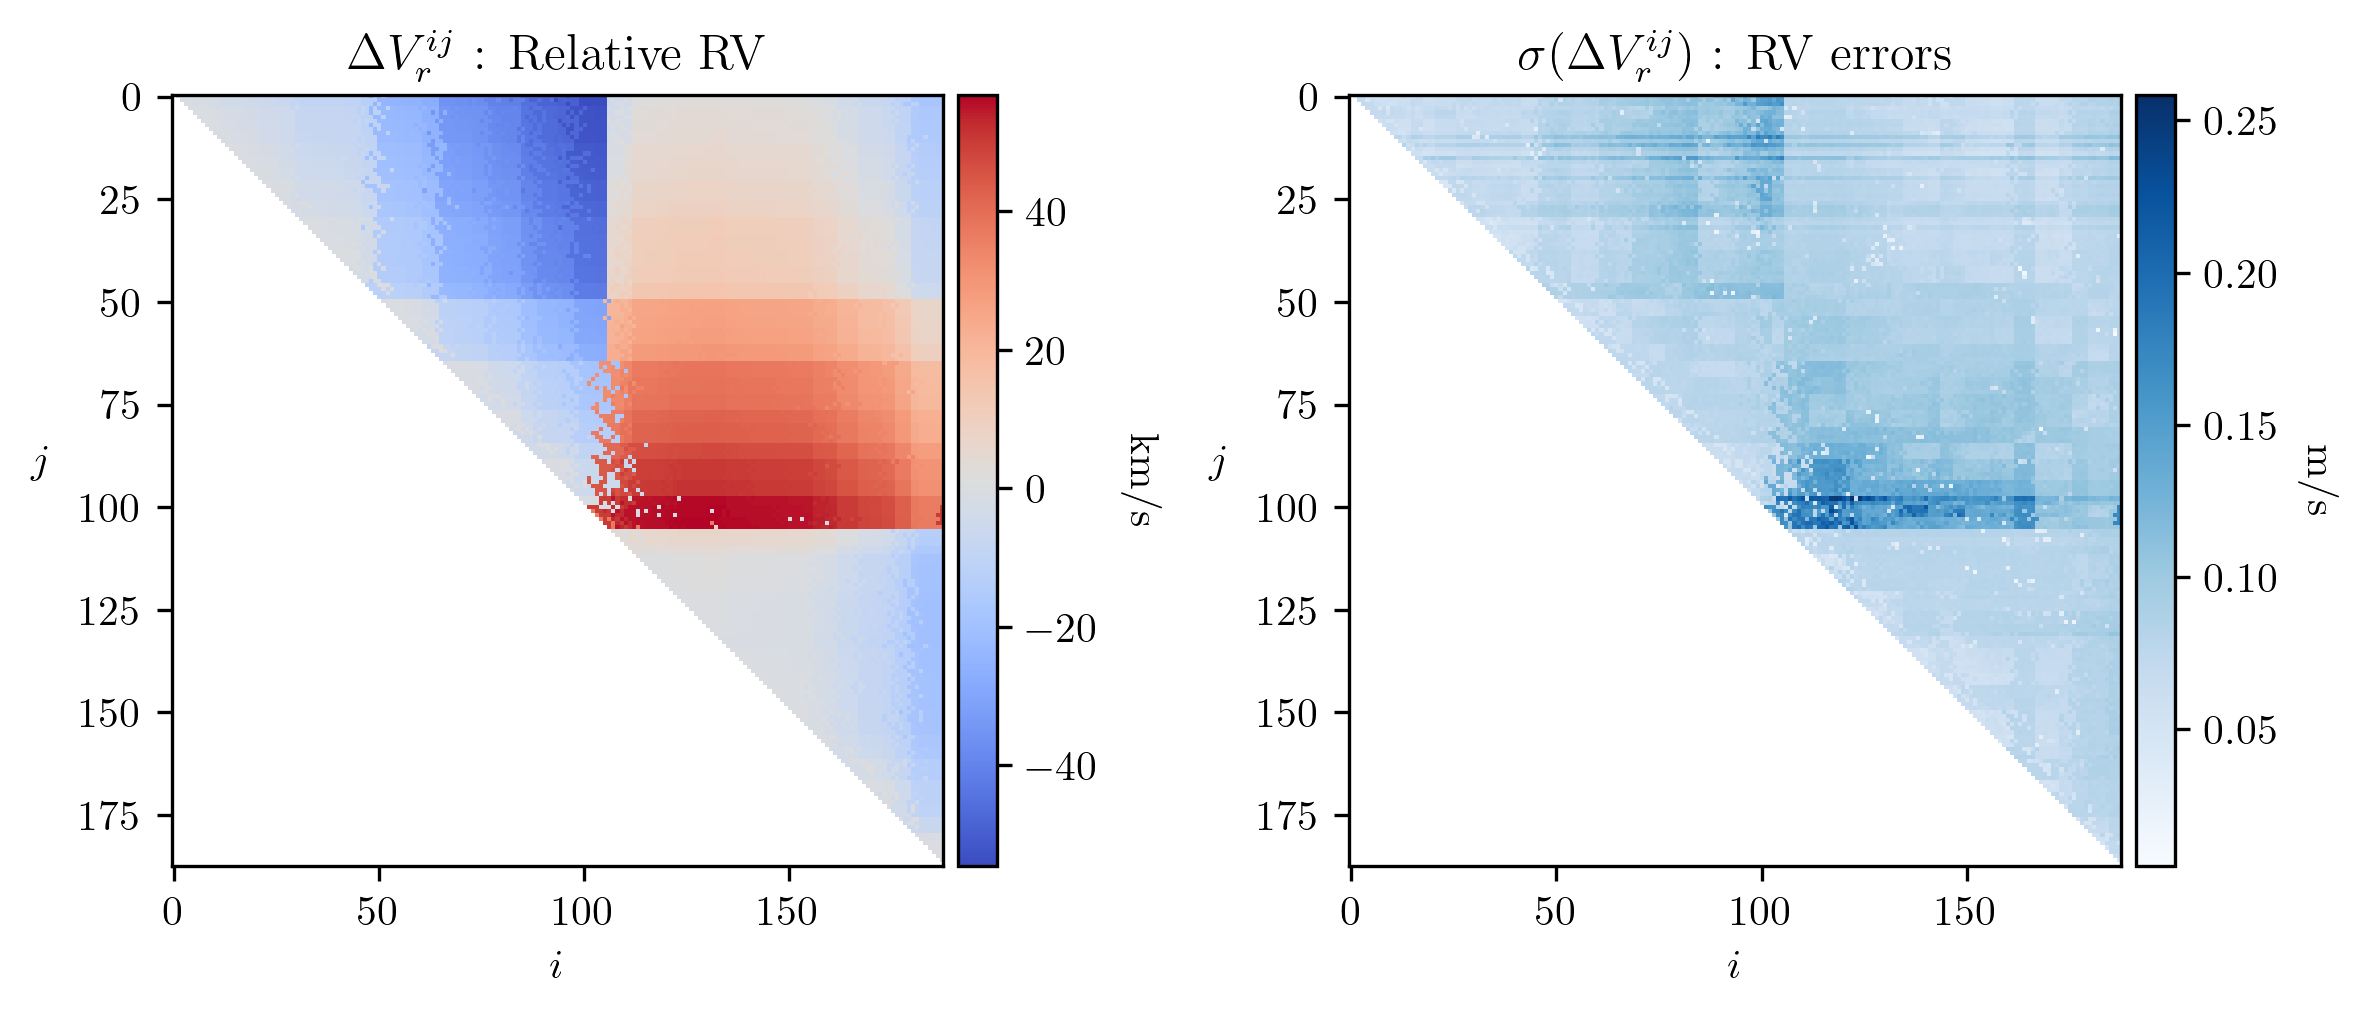

In [78]:
plot_matrix(diff_matrix, diff_matrix_err, plot_ratio=False, kms=True, colormap1="coolwarm", 
    # save_as="latex/figures/shfits_matrix_non_bary.pdf"
)

### Final RV plots:

In [107]:
def prepare_data_for_plot(file, path):
    result, coords = np.load(file, allow_pickle=True)
    matrix = parse_matrix_results(result, coords, median_err=False, use_median=True)
    m, rv, rv_err, days = matrix_reduce(*matrix, path=path, plot=False, with_date_duplicates=True)
    return rv, rv_err, days

##### HD 34411

In [6]:
rv, rv_err, days = prepare_data_for_plot("lily_data_results/34411_all_baryTrue_err1_dist05_area02_chi2.npy", path=SPECTRA_PATH_34411)

-7.0 9.0


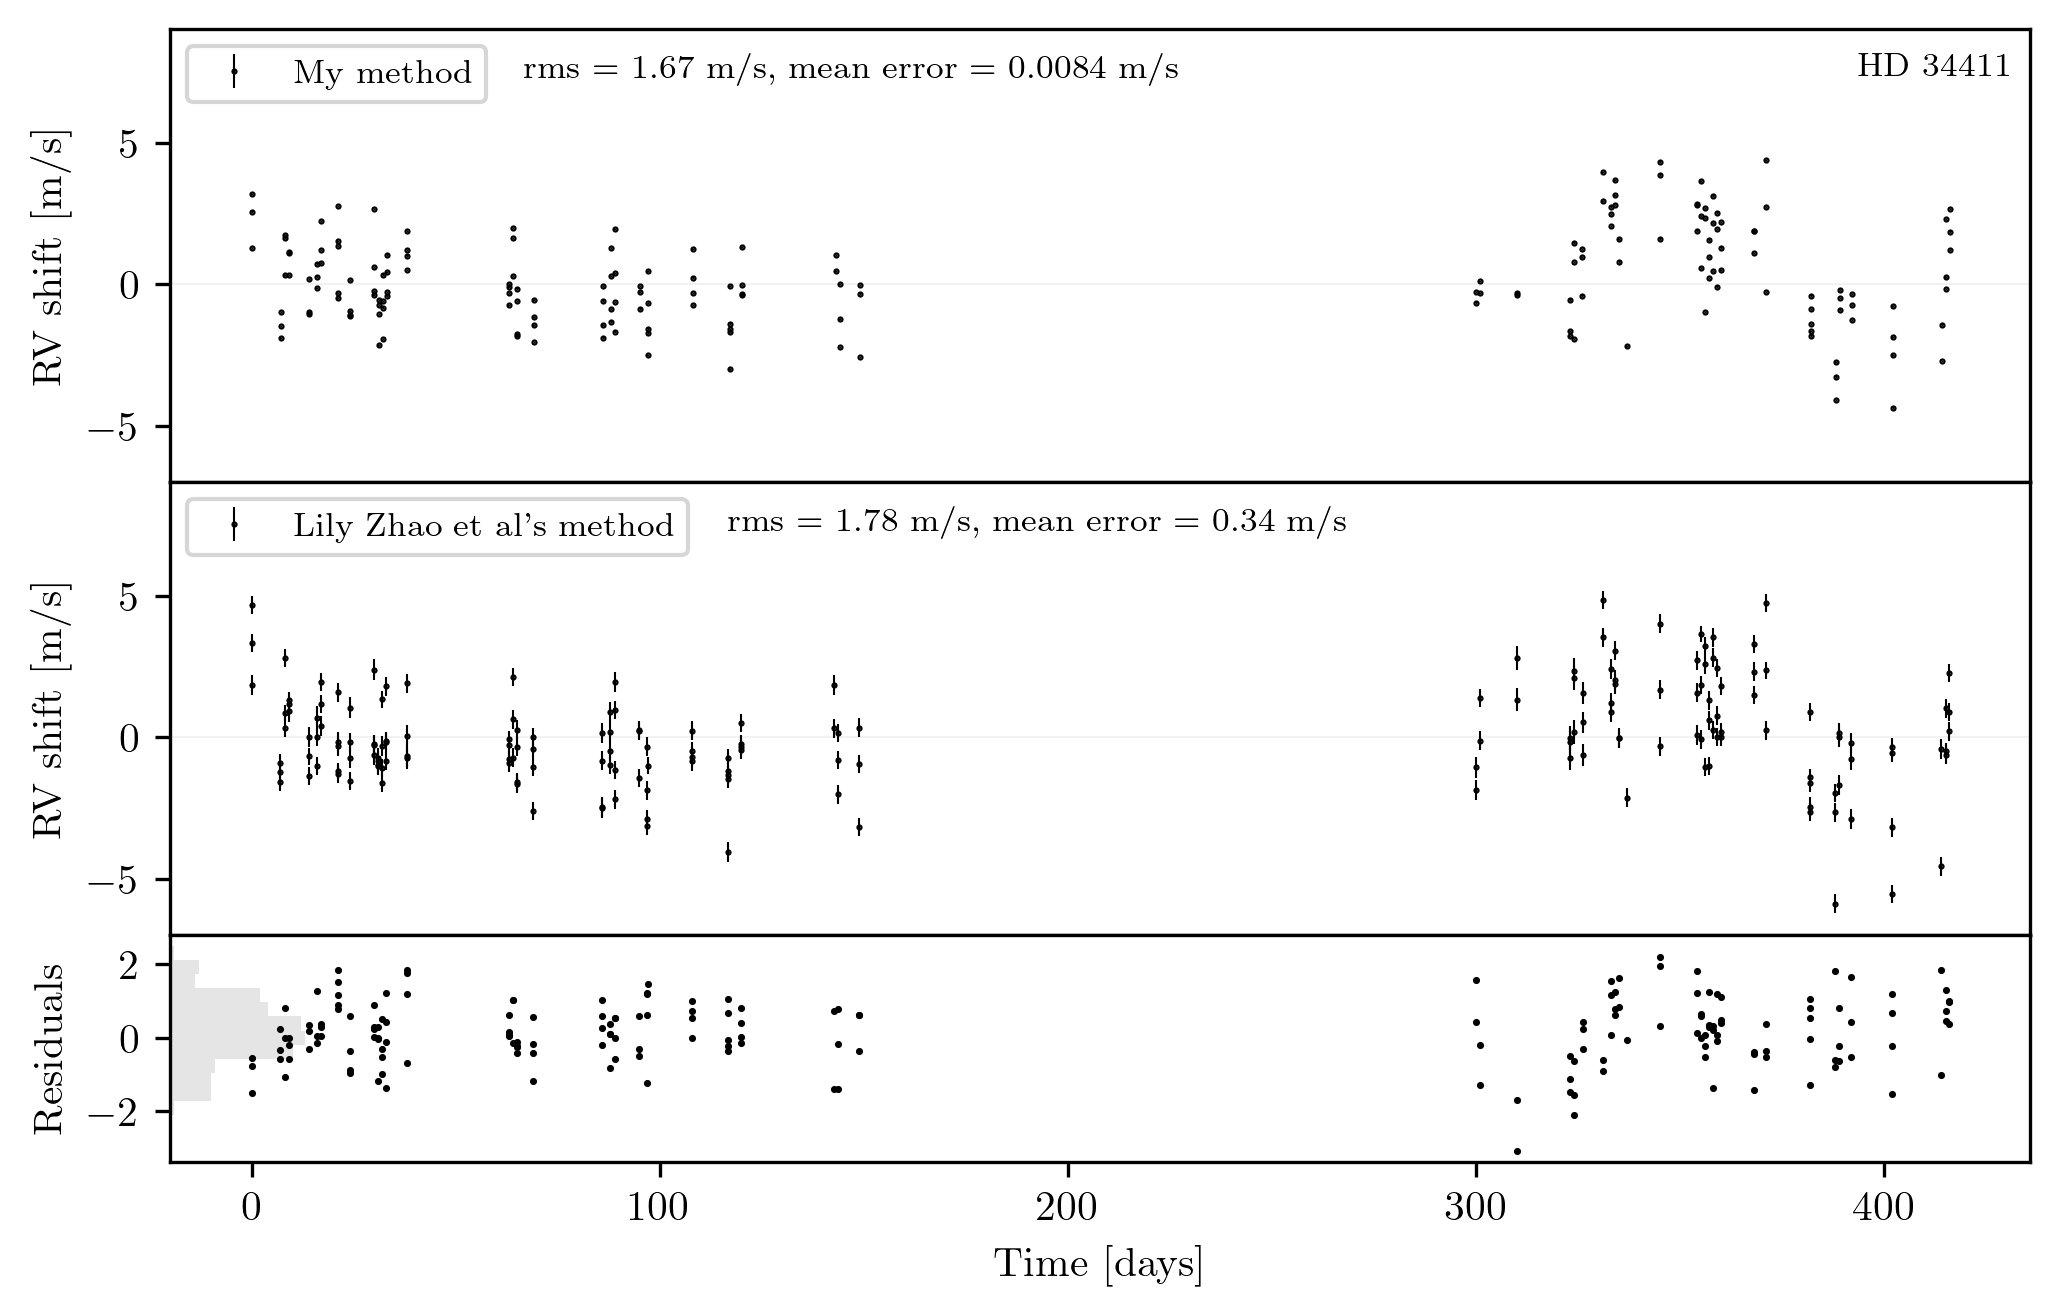

In [75]:
plot_compare_lily(rv, rv_err, days, 
    lily_data_file="34411_activity.csv",
    # save_as="latex/figures/HD34411_barycentric_rv_vs_lily.pdf",
    star_name="HD 34411"
)

##### HD 101501

In [7]:
HD101501 = prepare_data_for_plot("lily_data_results/101501_all_baryTrue_err1_dist05_area02_chi2.npy", path=SPECTRA_PATH_101501)

-12.0 15.0


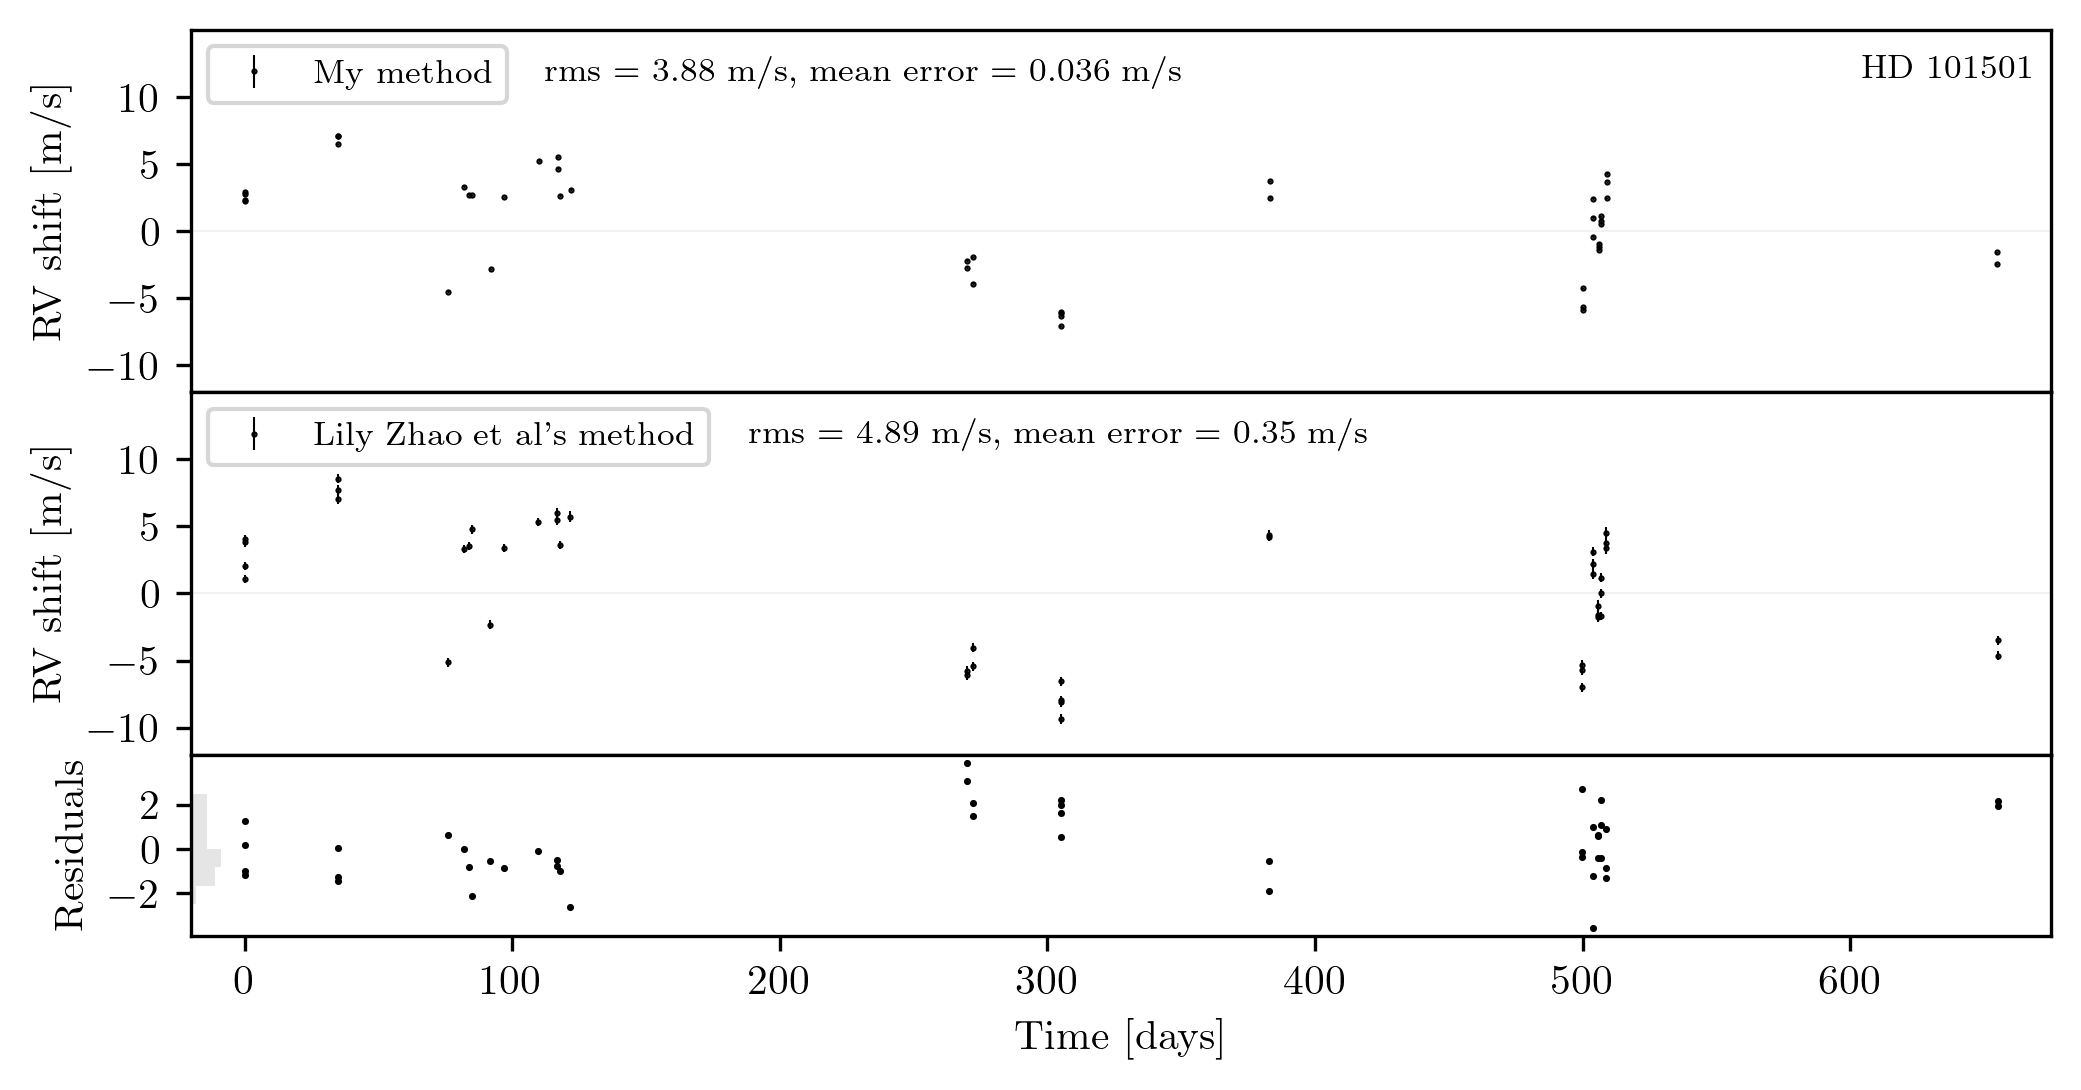

In [80]:
plot_compare_lily(*HD101501, 
    lily_data_file="101501_activity.csv",
    save_as="latex/figures/HD101501_barycentric_rv_vs_lily.pdf",
    star_name="HD 101501",
    padding_top=6,
    padding_bottom=2,
    ticks=[-10, -5, 0, 5, 10],
    small_height=True
)

##### HD 10700

In [12]:
HD10700 = prepare_data_for_plot("lily_data_results/10700_all_baryTrue_err1_dist05_area02_chi2.npy", path=SPECTRA_PATH_10700)

-7.0 8.0


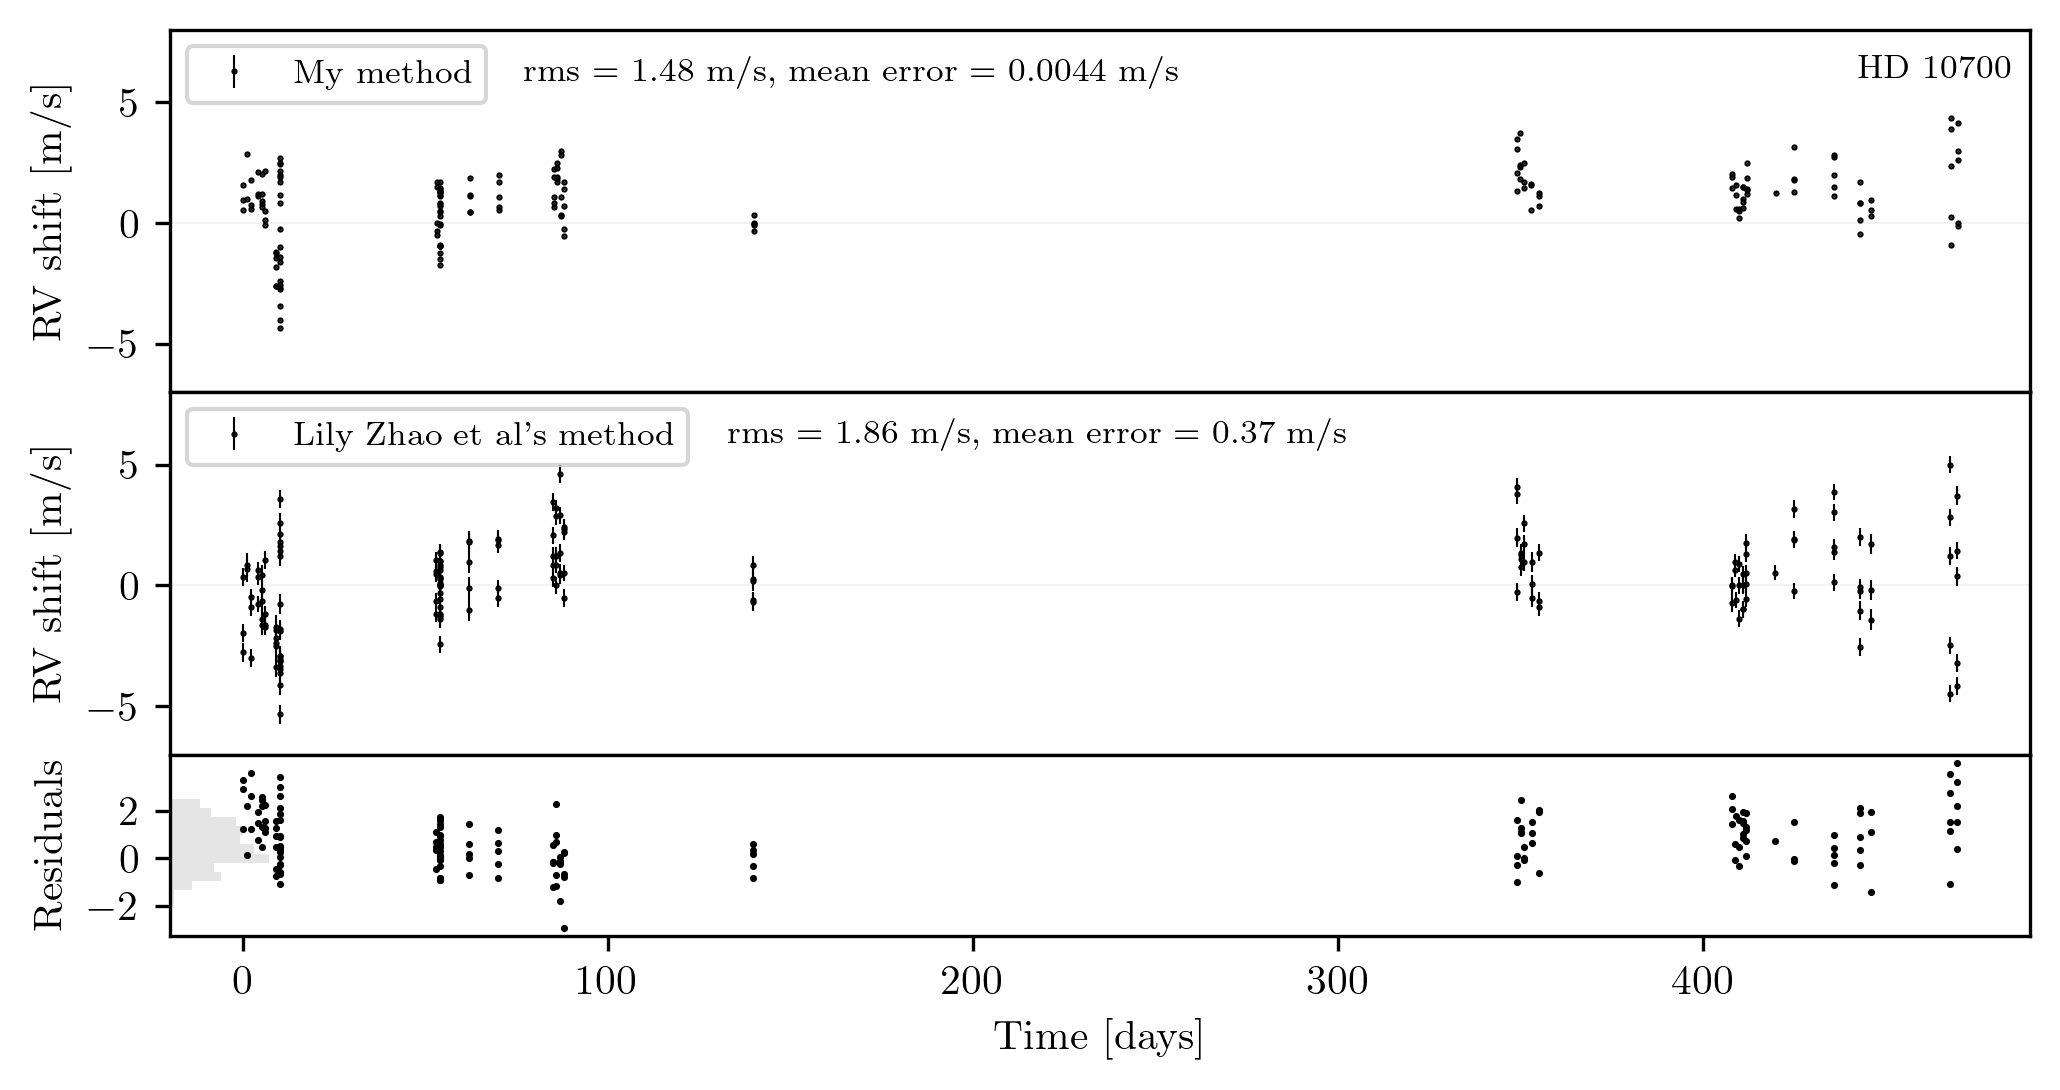

In [79]:
plot_compare_lily(*HD10700, 
    lily_data_file="10700_activity.csv",
    save_as="latex/figures/HD10700_barycentric_rv_vs_lily.pdf",
    star_name="HD 10700",
    padding_top=3,
    small_height=True
)

##### HD 26965

In [76]:
HD26965 = prepare_data_for_plot("lily_data_results/26965_all_baryTrue_err1_dist05_area02_chi2.npy", path=SPECTRA_PATH_26965)

-9.0 10.0


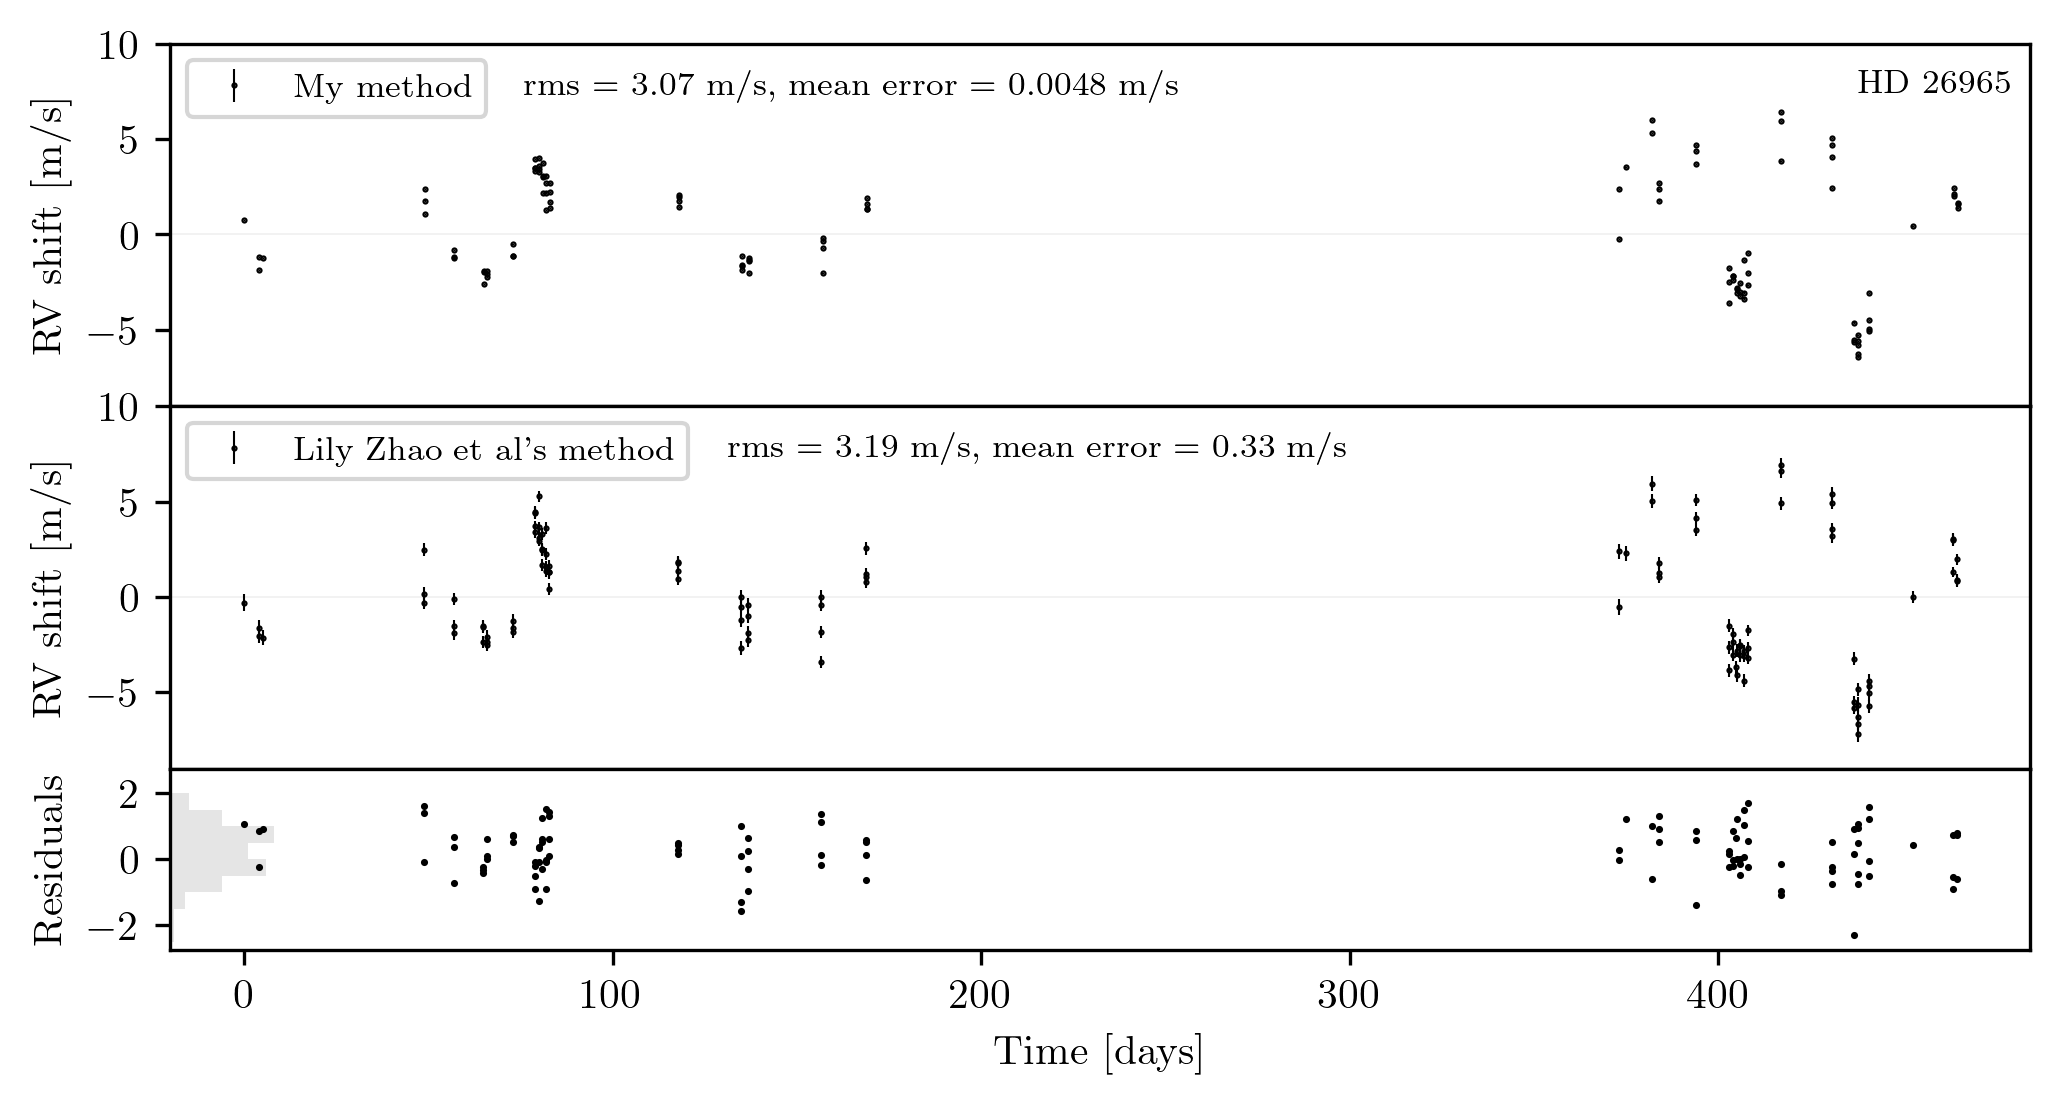

In [78]:
plot_compare_lily(*HD26965, 
    lily_data_file="26965_activity.csv",
    save_as="latex/figures/HD26965_barycentric_rv_vs_lily.pdf",
    star_name="HD 26965",
    padding_top=3,
    small_height=True
)

### N_points in RV shift interpolation

1255 peaks found
1211 peaks found
220 matches found


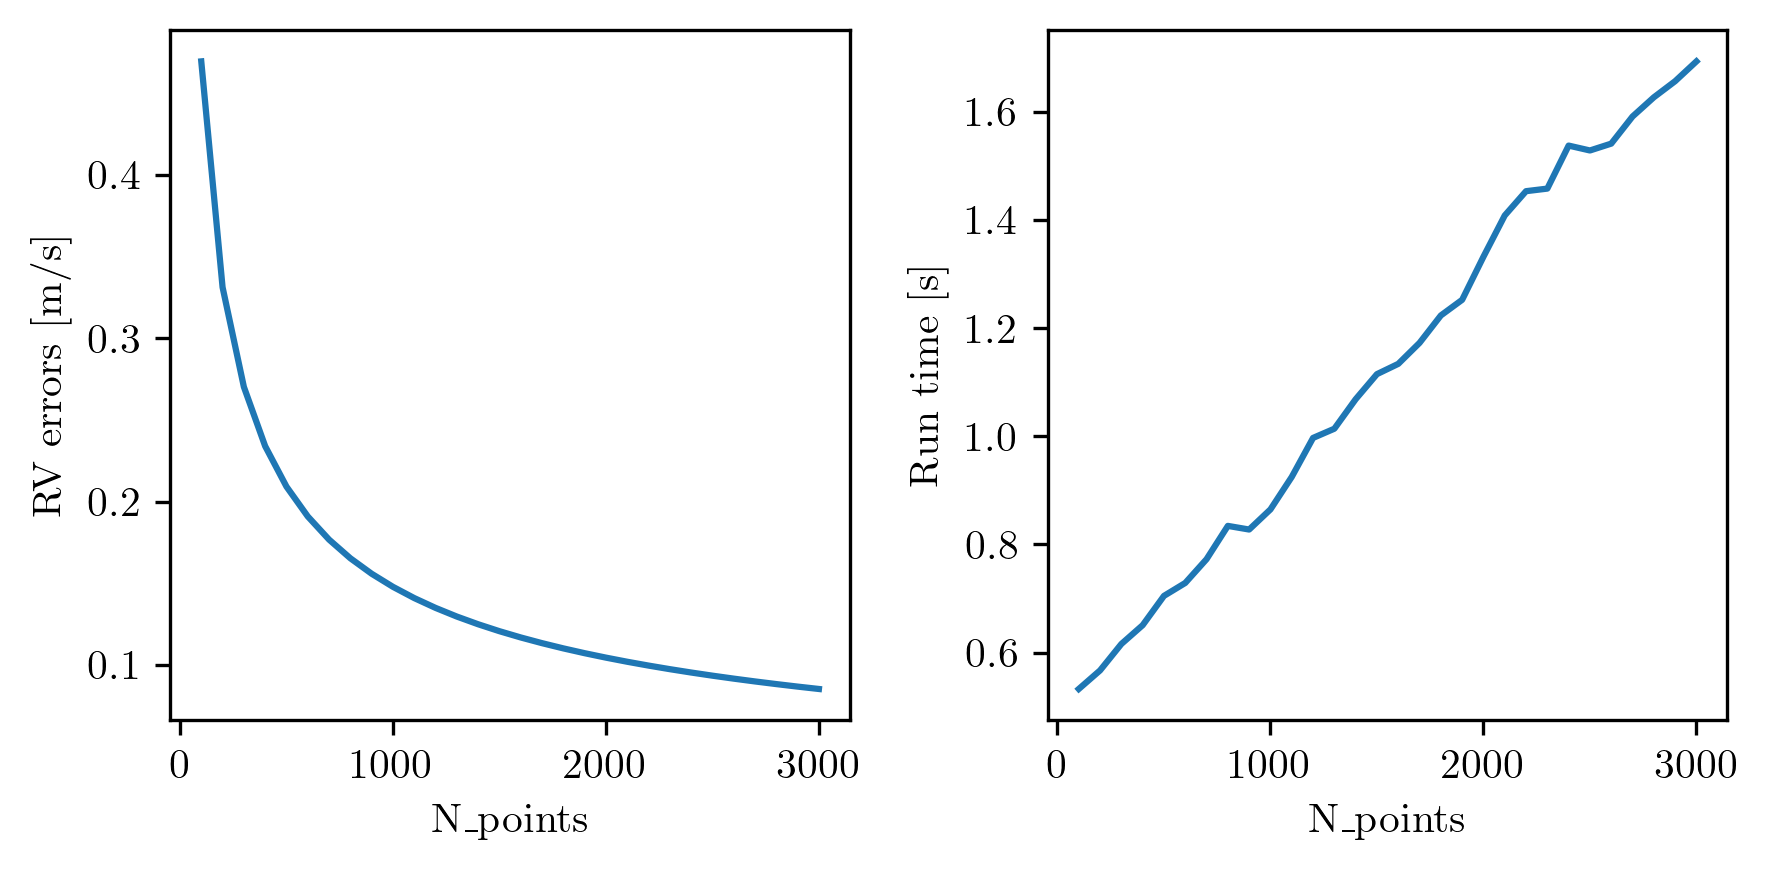

In [13]:
import time

filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_34411)
file1, file2 = filenames[1], filenames[20]
matches = find_feature_matches(find_features(file1), find_features(file2))

interp_sizes = np.linspace(100, 3000, 30)
shifts_list = []
run_times = []
for s in interp_sizes:
    start = time.time()
    shifts = compute_all_feature_shifts(matches, plot=False, interp_size=int(s))
    run_times.append(time.time() - start) # in seconds
    shifts = filter_z_test(shifts)
    shifts_list.append(shifts)

shifts_list = np.asarray(shifts_list)

err_mean = []
for r in shifts_list:
    shift_mean, shift_mean_err = weighted_mean(r[:, 0], r[:, 1])
    err_mean.append(shift_mean_err)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,3))

ax1.plot(interp_sizes, err_mean)
ax1.set_xlabel("N_points")
ax1.set_ylabel("RV errors [m/s]")

ax2.plot(interp_sizes, run_times)
ax2.set_xlabel("N_points")
ax2.set_ylabel("Run time [s]")

fig.tight_layout()


### RV extraction data overview

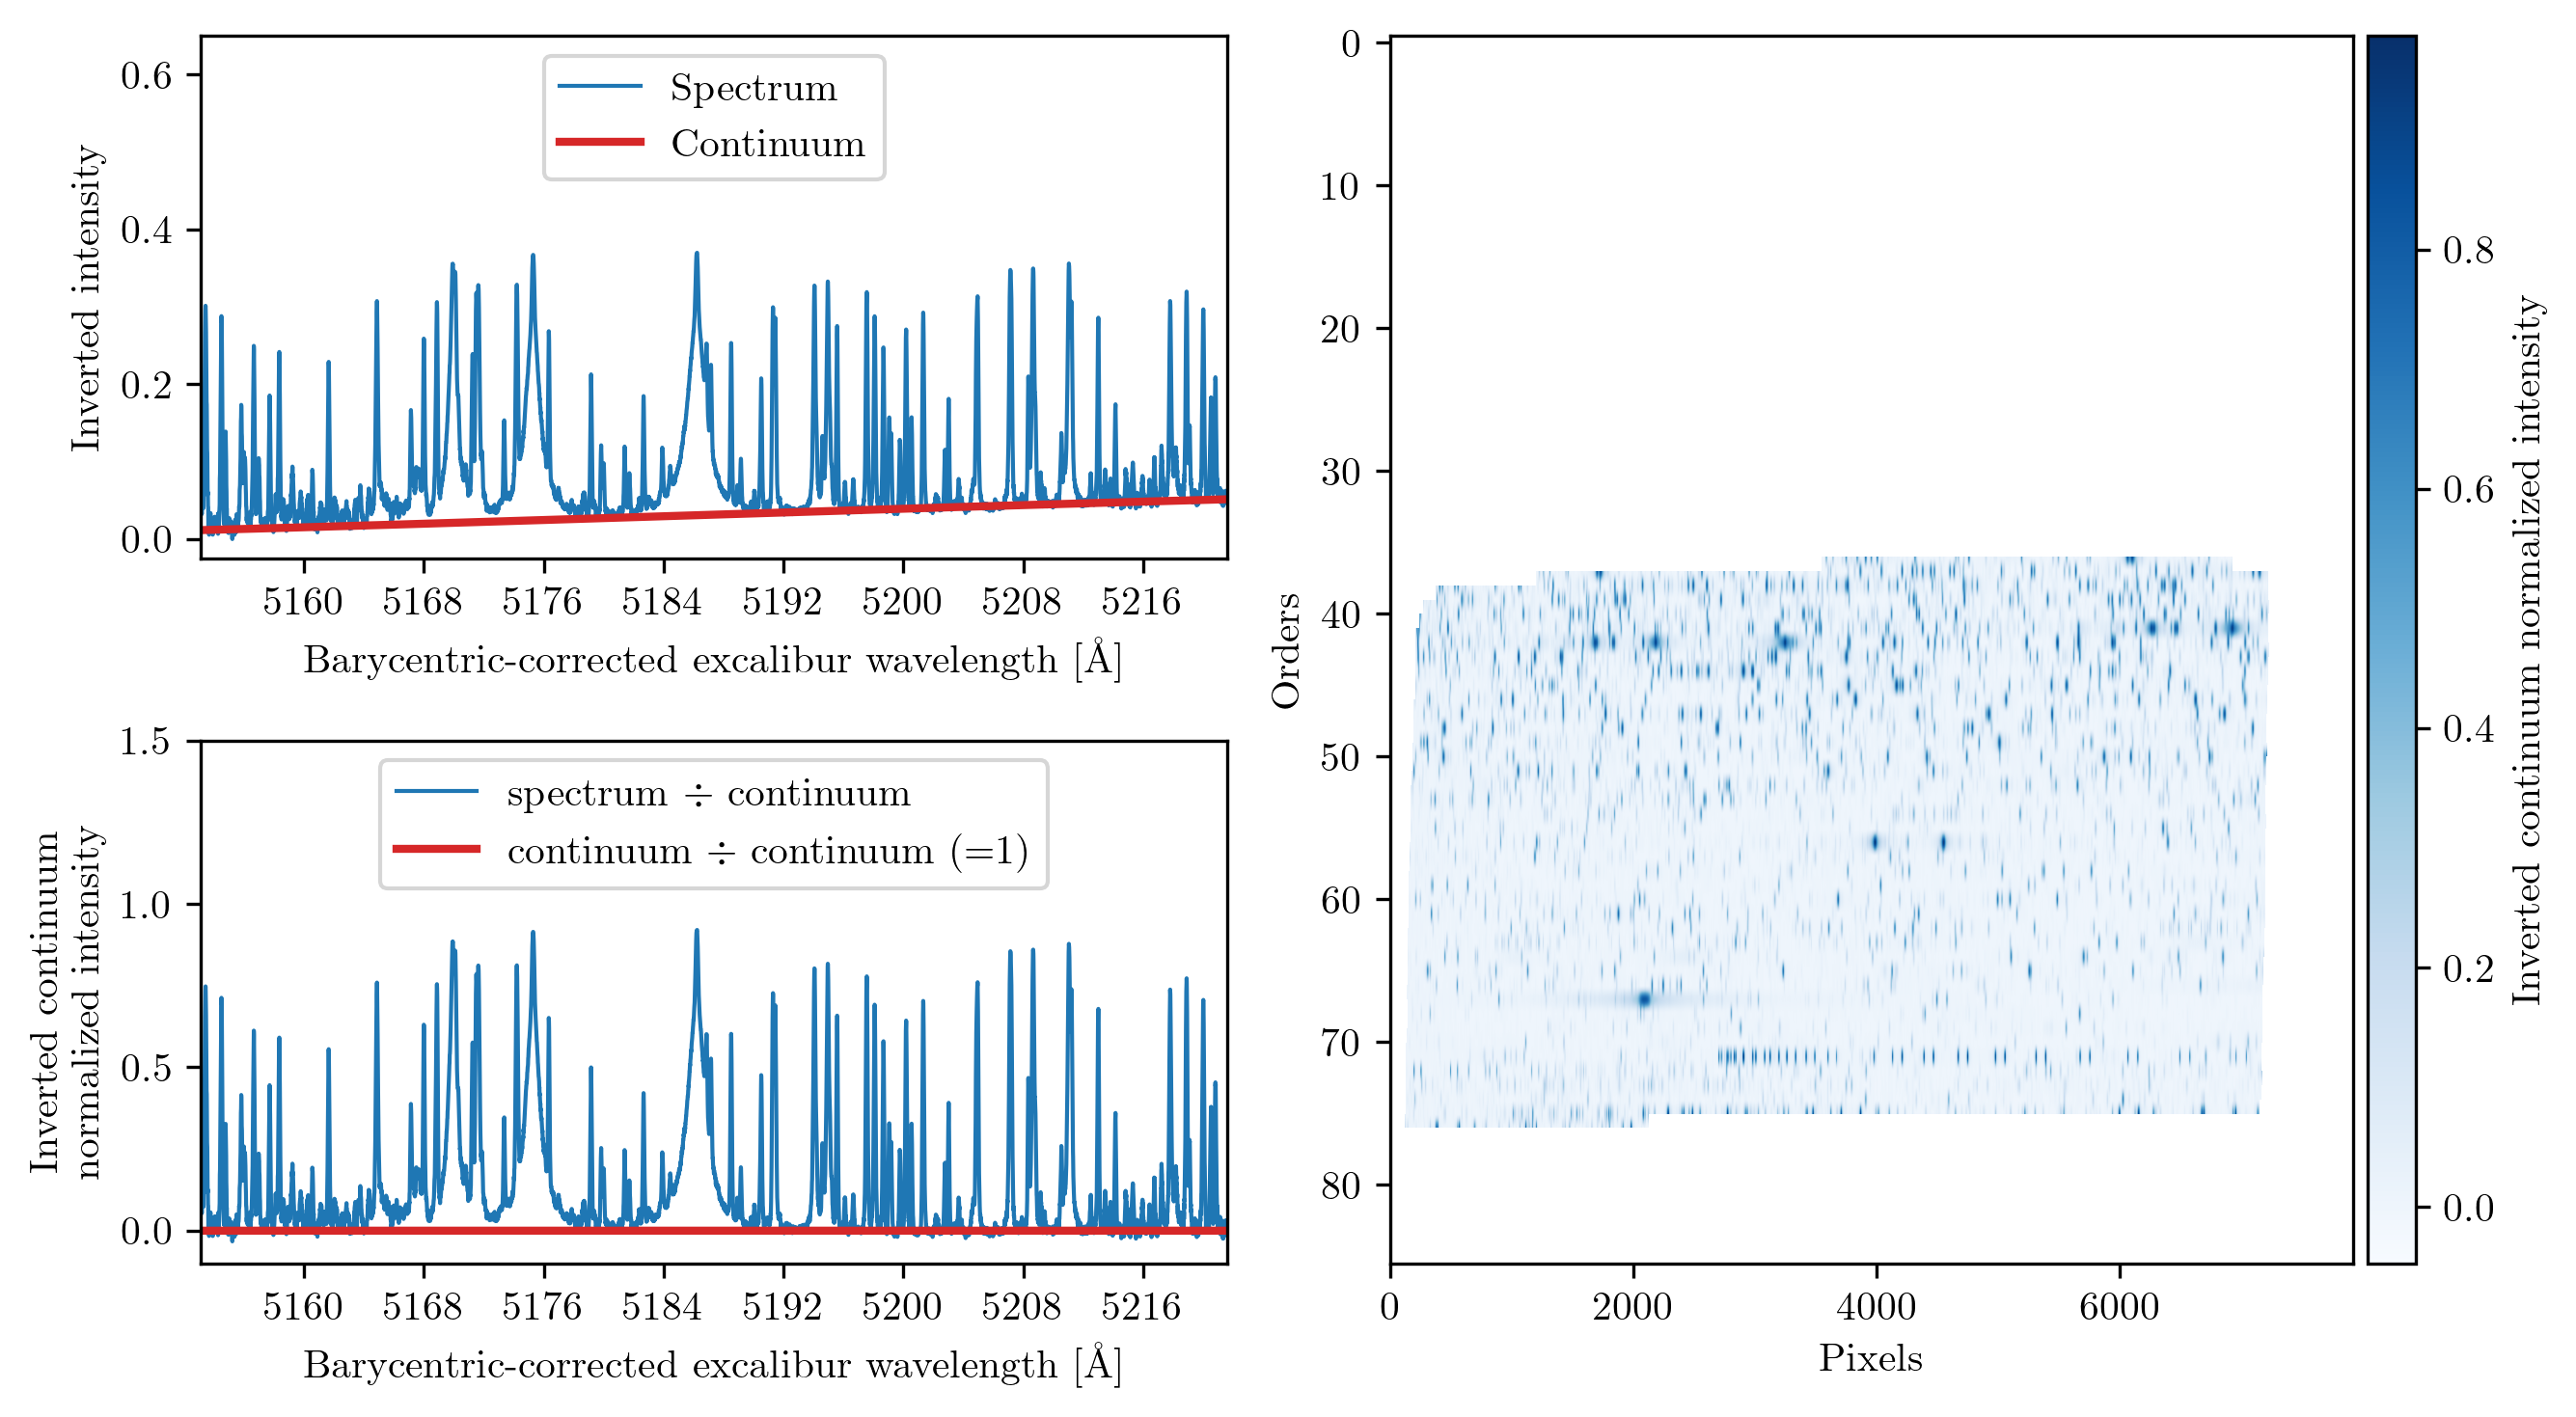

In [122]:
filenames = get_all_spectra_filenames(SPECTRA_PATH_34411)
SPECTRA_DATA = load_spectra_fits(filenames[0])

orders_pix = np.array([ 1 - SPECTRA_DATA['spectrum'][o]/SPECTRA_DATA['continuum'][o] for o in np.arange(len(SPECTRA_DATA['spectrum']))]) # create 2d array

fig = plt.figure(figsize=(9,5)) 
gs = fig.add_gridspec(2, 2) 
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0]) 
ax3 = fig.add_subplot(gs[:, 1]) 

order = 42

# Plot 1
y, y_err, x = get_spec_wavel(SPECTRA_DATA, order, continuum_normalized=False)
ax1.plot(x, max(y) - y, label="Spectrum", color=my_colors_blue, lw=1)

# Plot continuum
excalibur_mask  = SPECTRA_DATA['EXCALIBUR_MASK'][order]
cont = SPECTRA_DATA['continuum'][order][excalibur_mask]
ax1.plot(x, max(y) - cont, linewidth=2, label="Continuum", color=my_colors_red)
center = np.mean([min(x), max(x)]) + 20

# Limits and axis
xlim_min, xlim_max = center - 10, center + 10
xlim_min, xlim_max = min(x), max(x)
ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(-0.025, 0.65)
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# labels
ax1.set_xlabel("Barycentric-corrected excalibur wavelength [Å]")
ax1.set_ylabel("Inverted intensity")
ax1.legend(loc = "upper center")

# Plot 2:
y, y_err, x = get_spec_wavel(SPECTRA_DATA, order, continuum_normalized=True)
ax2.plot(x, 1 - y, label=r"spectrum $\div$ continuum", color=my_colors_blue, lw=1)
ax2.plot(x, 1 - cont/cont, linewidth=2, label=r"continuum $\div$ continuum (=1)", color=my_colors_red)
ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(-0.1, 1.5)
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2.set_xlabel("Barycentric-corrected excalibur wavelength [Å]")
ax2.set_ylabel("Inverted continuum\nnormalized intensity")
ax2.legend(loc = "upper center")

# Plot masked filter
excalibur_mask  = SPECTRA_DATA['EXCALIBUR_MASK']
orders_pix[excalibur_mask == False] = np.nan
cs = ax3.imshow(orders_pix, aspect="auto", cmap=plt.get_cmap("Blues"))
cax = make_axes_locatable(ax3).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
cbar = fig.colorbar(cs, ax=ax3, cax=cax)
cbar.set_label("Inverted continuum normalized intensity")
# ax3.set_title("Inverted contimuum normalized\nspectrum with excalibur mask")
ax3.set_xlabel("Pixels")
ax3.set_ylabel("Orders")

fig.tight_layout()

# fig.savefig("latex/figures/rv_data_overview.pdf", bbox_inches="tight", dpi=300)


### Spectral Resolution

The spectral resolution given by
$$
R = \frac{\lambda}{\Delta\lambda}
$$

is ~150'000 for EXPRES. For 5000 angstrom this equals a wavelength shift of

$$
\Delta\lambda = \frac{5000 \text{Å}}{150'000} \approx 0.033 \text{Å}.
$$

A non-relativistic doppler shifted wavelength, $\lambda$, is given by

$$
    \lambda = \lambda_0 \times \Big(1 + \frac{v}{c} \Big),
$$

where $\lambda_0$ is the emited wavelength. From this we can find the velocity as

$$
    v = (\lambda / \lambda_0 - 1) \times c
$$

In [ ]:
c = 299792458   # m/s

# For a given wavelegnth, say 5000 angstrom (in meters)
λ_0 = 5000e-10

# the spectral resolution in wavelength is
Δλ = λ_0/150000

# the minimum detectable shifted wavelength is thus
λ = λ_0 + Δλ

v = (λ/λ_0 - 1) * c 
print(f"{v:.2f} m/s")


### Match selection

In [164]:
def load_x_y(index, order, bary):
    fits_data = load_spectra_fits(get_spectra_filenames_without_duplicate_dates()[index])
    y, y_err, x = get_spec_wavel(fits_data, order, continuum_normalized=True, bary_corrected=bary)
    y = 1 - y # invert
    return x, y, y_err

def plot_data_with_match(ax, file_index1, file_index2, k, max_area_diff=0.2, max_dist=1, bary=False, xrange=1, print_dist=False, lw=1):
    filenames = get_spectra_filenames_without_duplicate_dates()
    features1 = find_features(filenames[file_index1], use_bary_correction=bary, scale_up_errors=False)
    features2 = find_features(filenames[file_index2], use_bary_correction=bary, scale_up_errors=False)
    matches = find_feature_matches2(features1, features2, max_dist=max_dist, max_area_diff=max_area_diff)
    
    f1 = matches[k][0]
    f2 = matches[k][1]

    order1 = f1[5]
    λ1, λ2 = f1[3], f2[3]
    center = np.mean([λ1, λ2])

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,2))

    ax.set_xlim(center - xrange, center + xrange)

    ax.plot(f1[0], f1[1], ".", color=my_colors_red, label="Matched feature 1")
    ax.plot(f2[0], f2[1], ".", color=my_colors_blue, label="Matched feature 2")

    ΔA = np.sum(f1[1]) - np.sum(f2[1])
    # print(f"ΔΑ = {):.3}")

    # Print area diff on plot
    text = "A$_{cut}=$ " + str(max_area_diff) + "\n$\Delta$A = " + f"{ΔA:.3f}"

    if print_dist:
        text = text + "\ndist = " + f"{(f1[3] - f2[3]):.3}"

    ax.text(0.75, 0.95, text, size = 8, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

    # Plot data
    x1, y1, yerr1 = load_x_y(file_index1, order1, bary)
    x2, y2, yerr2 = load_x_y(file_index2, order1, bary)

    ax.plot(x1, y1, color=my_colors_red, lw=lw, label="Observation 1")
    ax.plot(x2, y2, color=my_colors_blue, lw=lw, label="Observation 2")
    


1267 peaks found
1236 peaks found
373 matches found : dist rejected 17, area rejected 868
1267 peaks found
1236 peaks found
305 matches found : dist rejected 17, area rejected 943


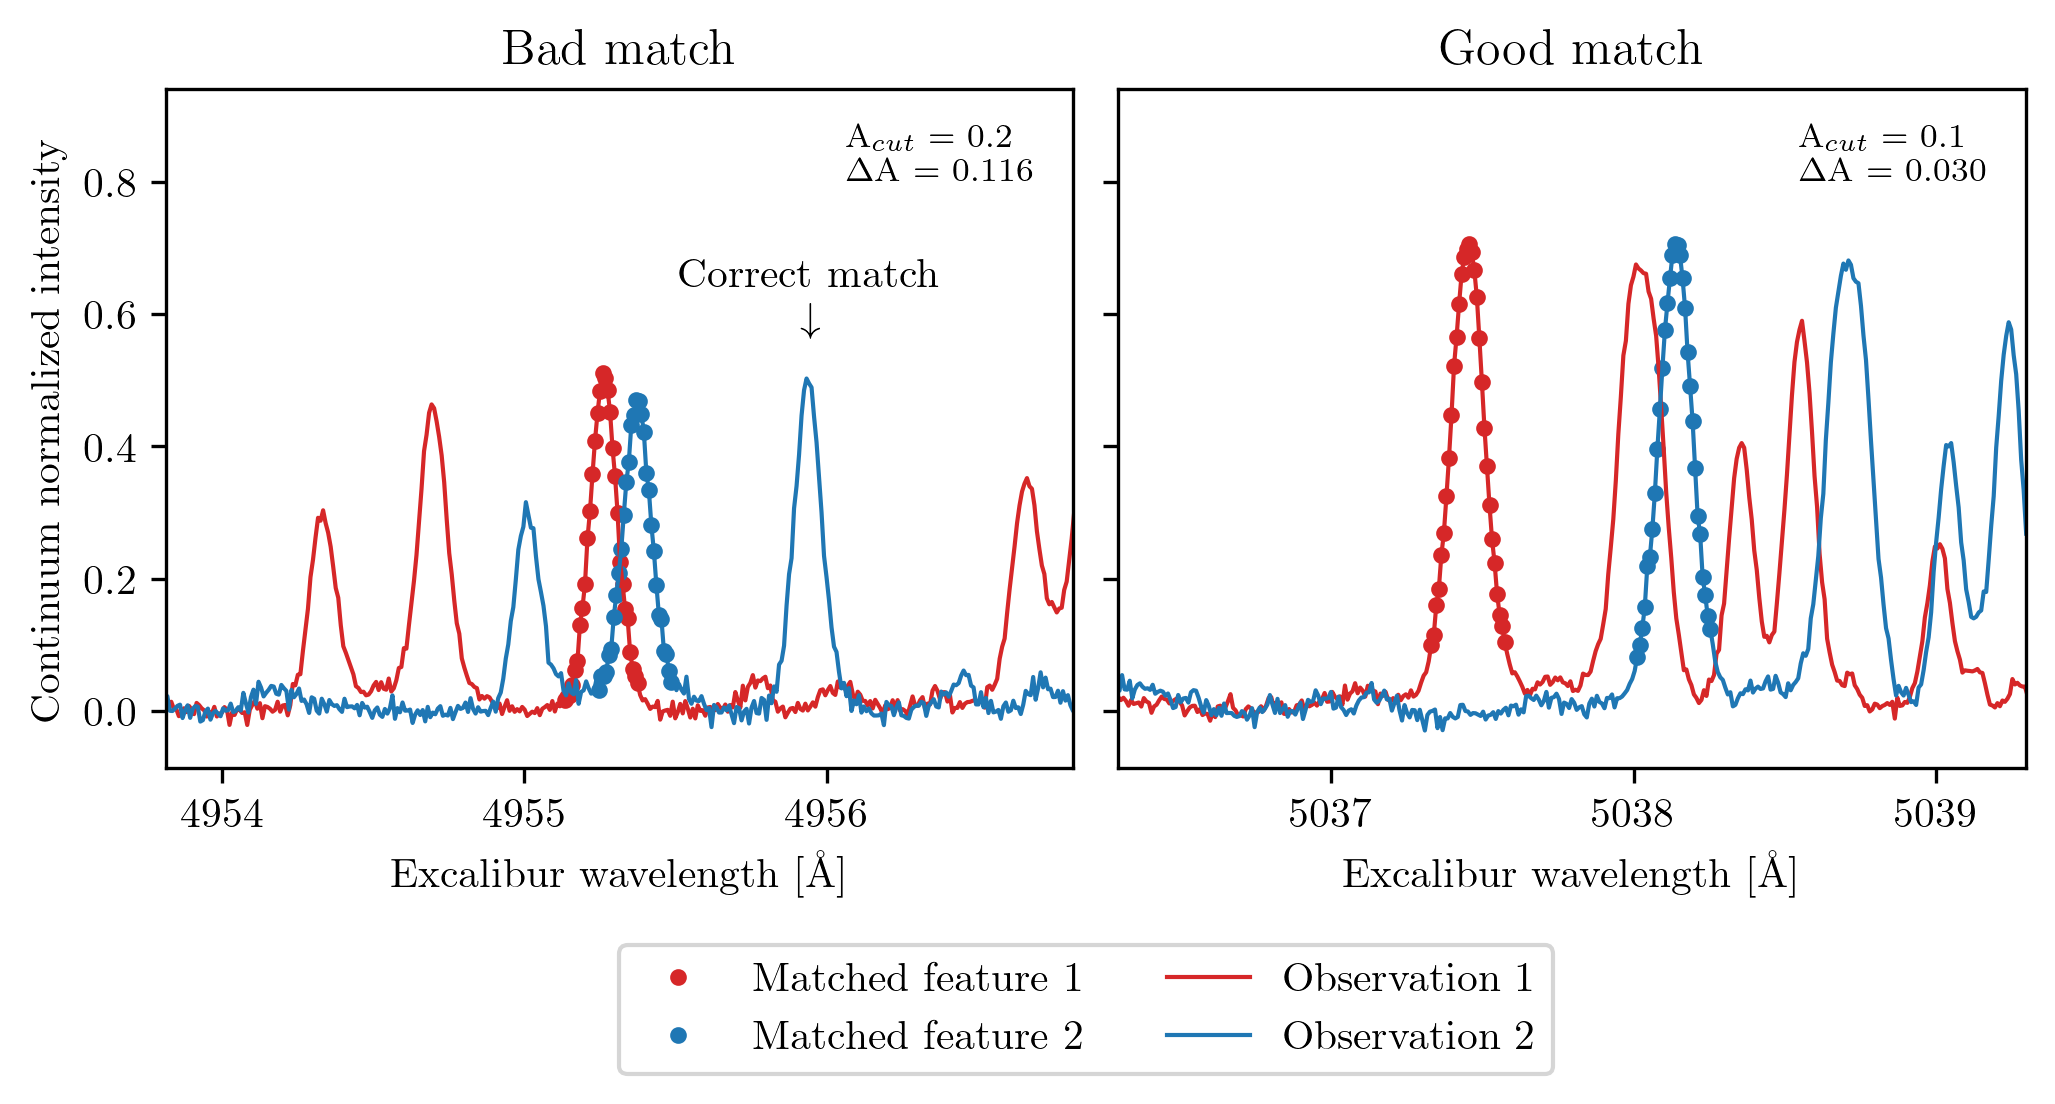

In [155]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,3), sharey=True)

plot_data_with_match(ax1, 0, 22, 5, max_area_diff=0.2, bary=False, xrange=1.5)
plot_data_with_match(ax2, 0, 22, 19, max_area_diff=0.1, bary=False, xrange=1.5)

ax1.set_xlabel("Excalibur wavelength [Å]")
ax2.set_xlabel("Excalibur wavelength [Å]")
ax1.set_ylabel("Continuum normalized intensity")
ax1.legend(ncol=2, loc=(0.5, -0.45))
ax1.set_title("Bad match")
ax2.set_title("Good match")

# Only show whole numbers on the x-axis
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

# Draw arrow and "Correct match"
text = "Correct match \n $\downarrow$"
ax1.text(0.71, 0.75, text, size = 10, horizontalalignment='center', verticalalignment='top', transform=ax1.transAxes)

# Share y-axis 
ax1.sharey(ax2)
fig.subplots_adjust(wspace=0.05, hspace=0)

# fig.savefig("latex/figures/good_match_bad_match.pdf", bbox_inches="tight", dpi=300)


### Weighted average vs. mean vs. median

In [129]:
filenames = get_spectra_filenames_without_duplicate_dates()
features1 = find_features(filenames[10], use_bary_correction=True, scale_up_errors=False)
features2 = find_features(filenames[12], use_bary_correction=True, scale_up_errors=False)
matches = find_feature_matches2(features1, features2, max_dist=0.1, max_area_diff=0.2)
shifts = compute_all_feature_shifts(matches, return_extra=True)

1224 peaks found
1266 peaks found
796 matches found : dist rejected 8, area rejected 416


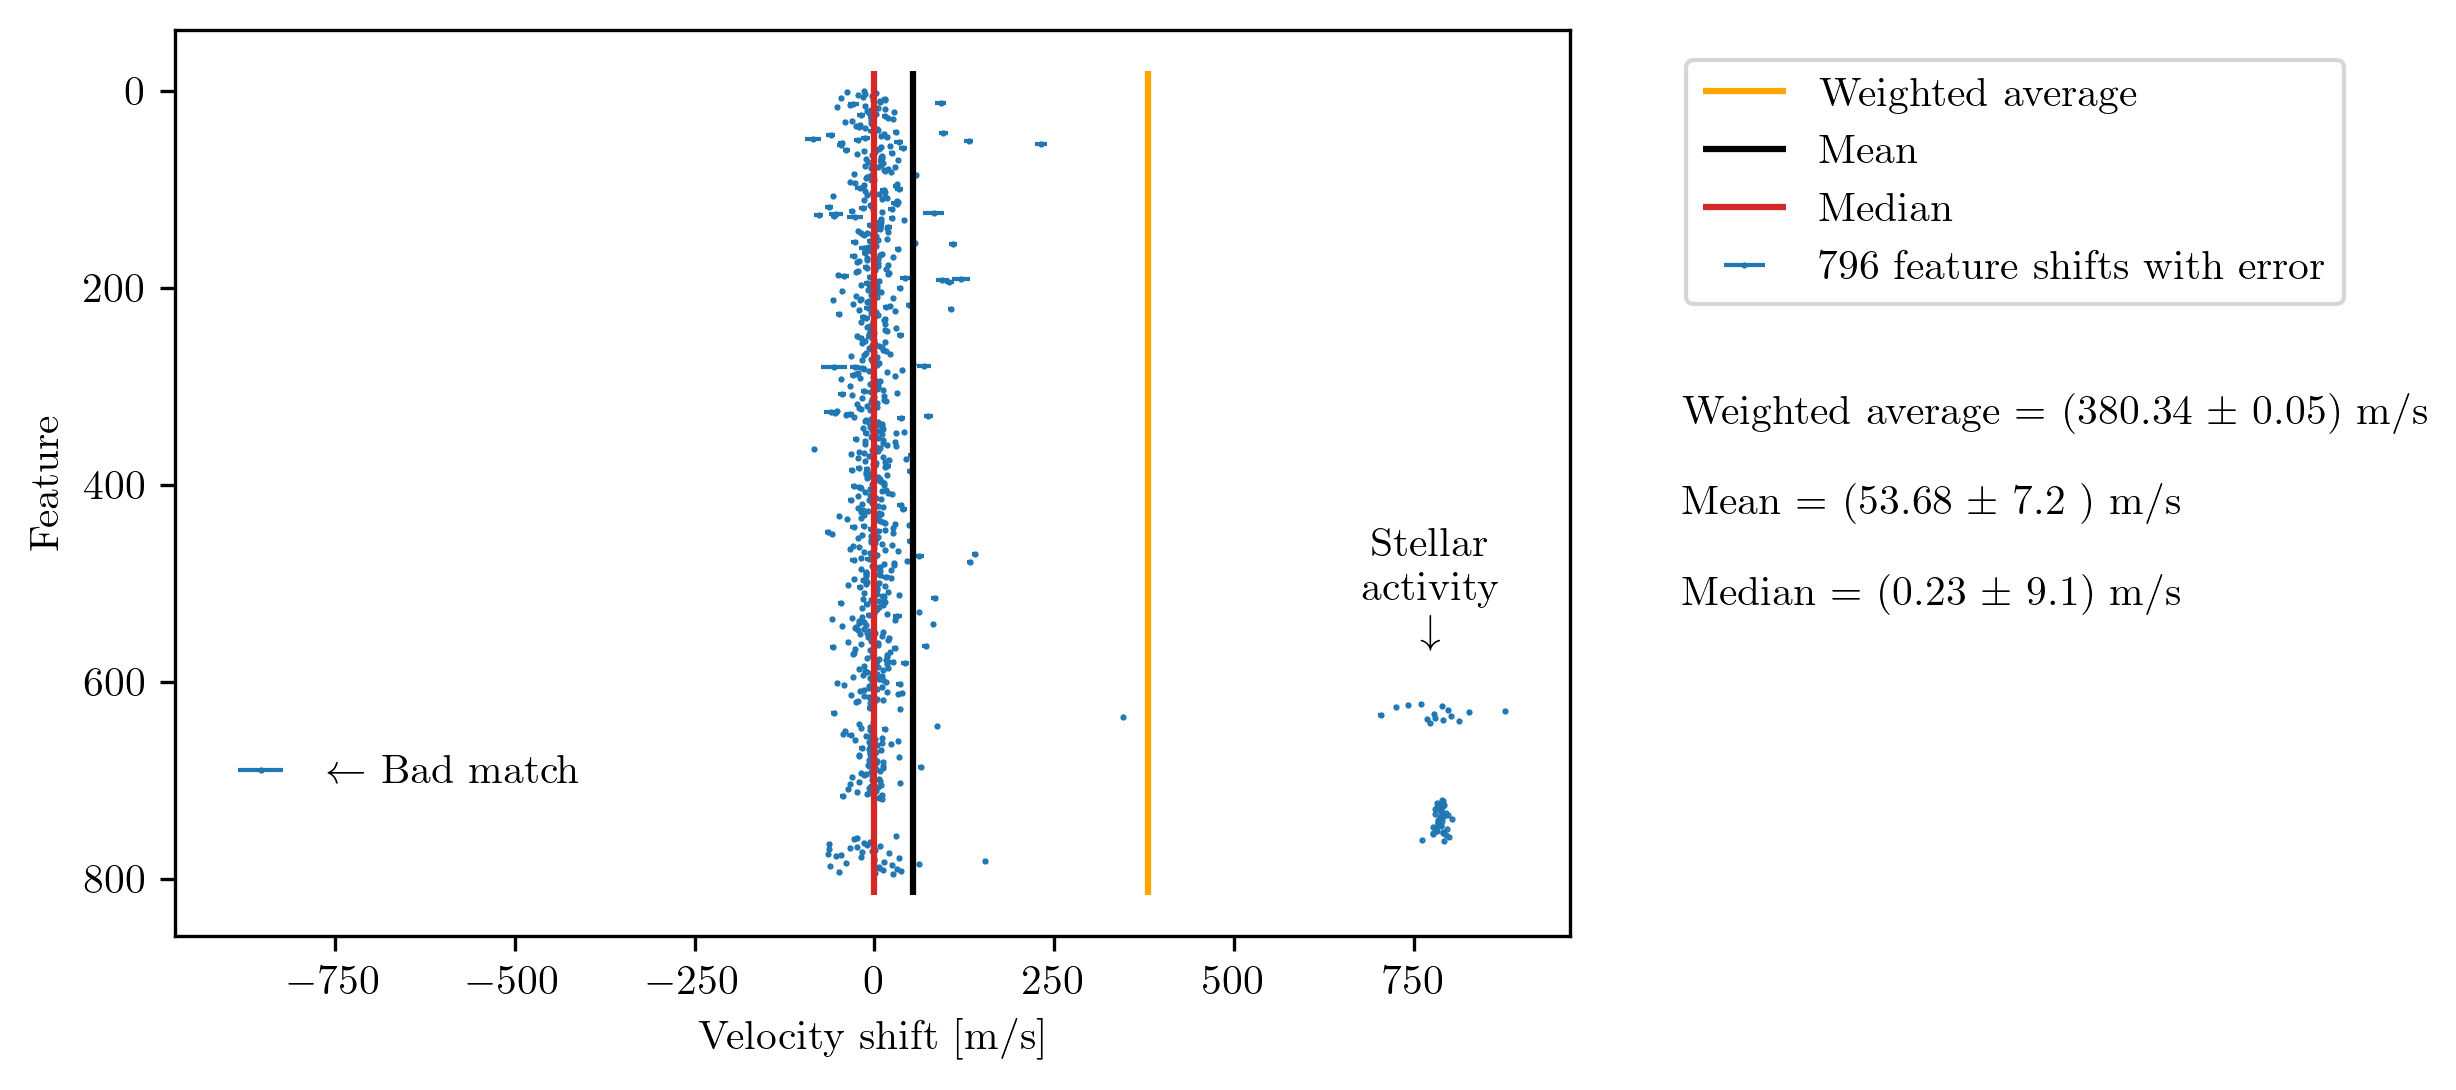

In [243]:
# For filenames[10] and filenames[12], bary, max_dist=0.1, max_area_diff=0.2

fig, ax = plt.subplots(figsize=(6,4))
_ = plot_features_shift(shifts, ax, draw_guides=True, guide_lw=1.5, side_text_y_loc=0.6, legend_x_loc=1.57)

text = "$\leftarrow$ Bad match"
ax.text(0.2, 0.2, text, size = 10, horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)

text = "Stellar\nactivity\n$\downarrow$"
ax.text(0.9, 0.45, text, size = 10, horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)

# fig.savefig("latex/figures/median-mean-weighted.pdf", bbox_inches="tight", dpi=300)

#### The bad match

1224 peaks found
1266 peaks found
796 matches found : dist rejected 8, area rejected 416


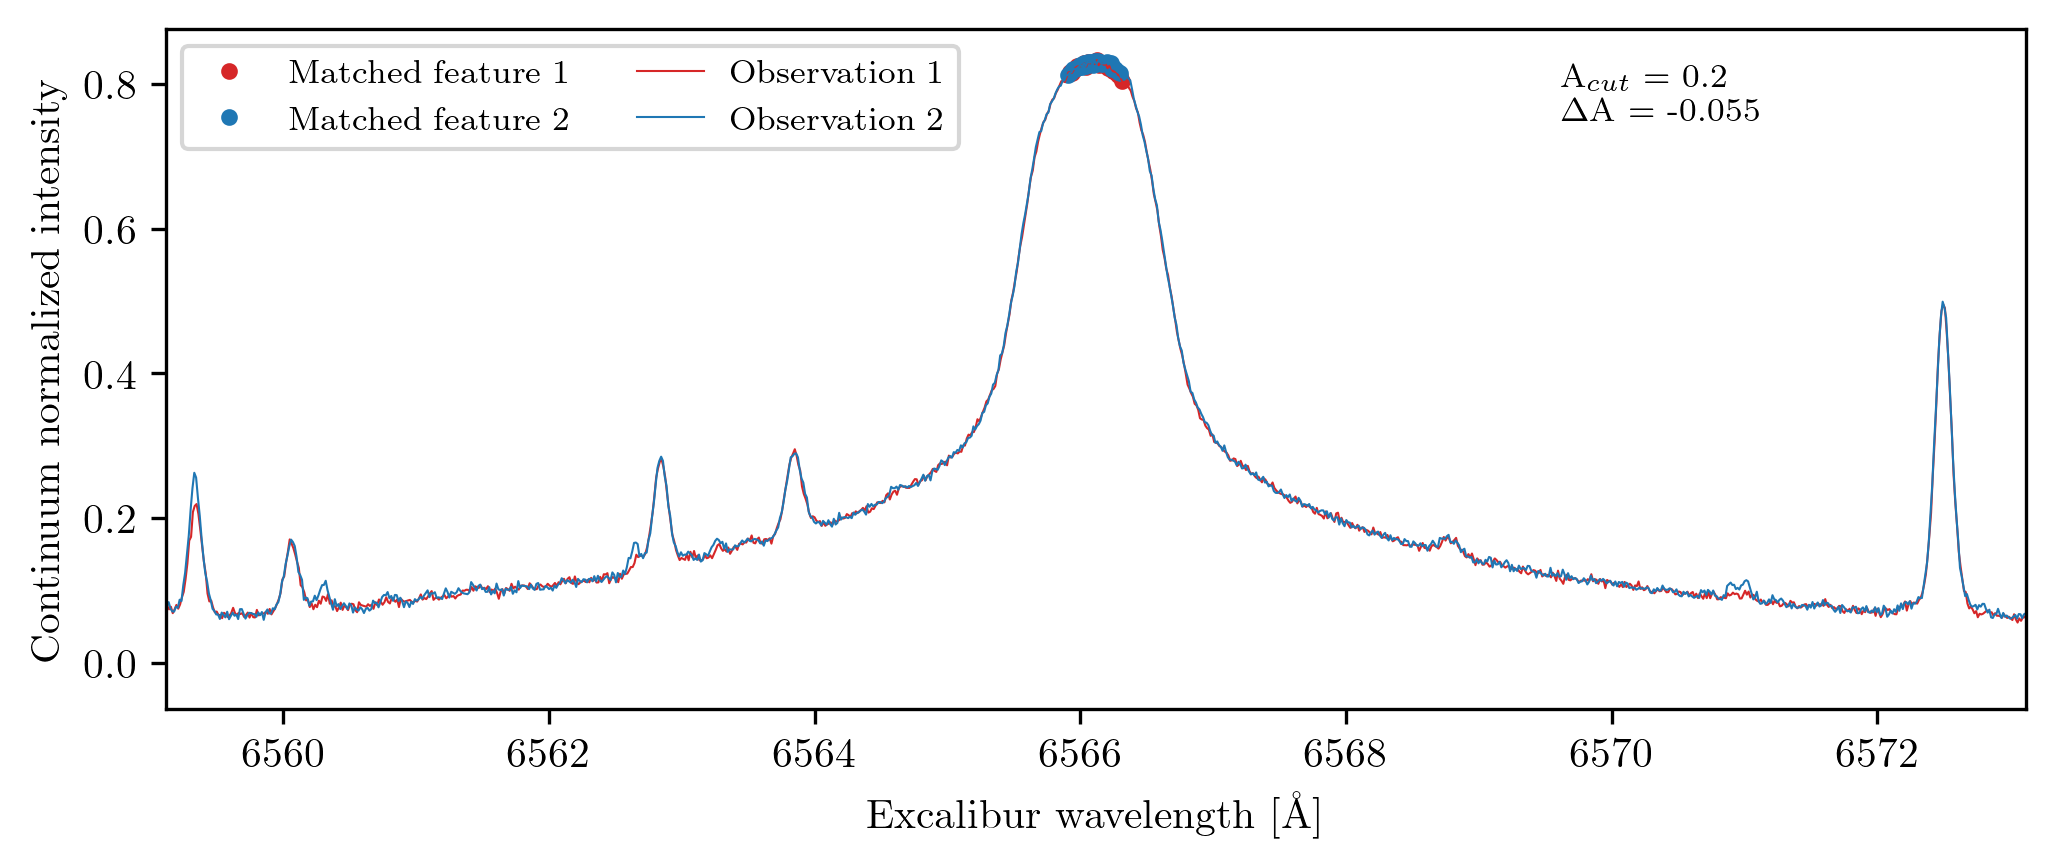

In [249]:
np.where(shifts < -500)
# plot_match(matches[690])

fig, ax = plt.subplots(figsize=(8, 3))
plot_data_with_match(ax, 10, 12, 690, max_area_diff=0.2, max_dist=0.1, bary=True, xrange=7, lw=0.5)
ax.legend(loc = "upper left", fontsize=8, ncol=2)
ax.set_xlabel("Excalibur wavelength [Å]")
ax.set_ylabel("Continuum normalized intensity")

# fig.savefig("latex/figures/bad_match_example.pdf", bbox_inches="tight", dpi=300)


#### The stellar activity features

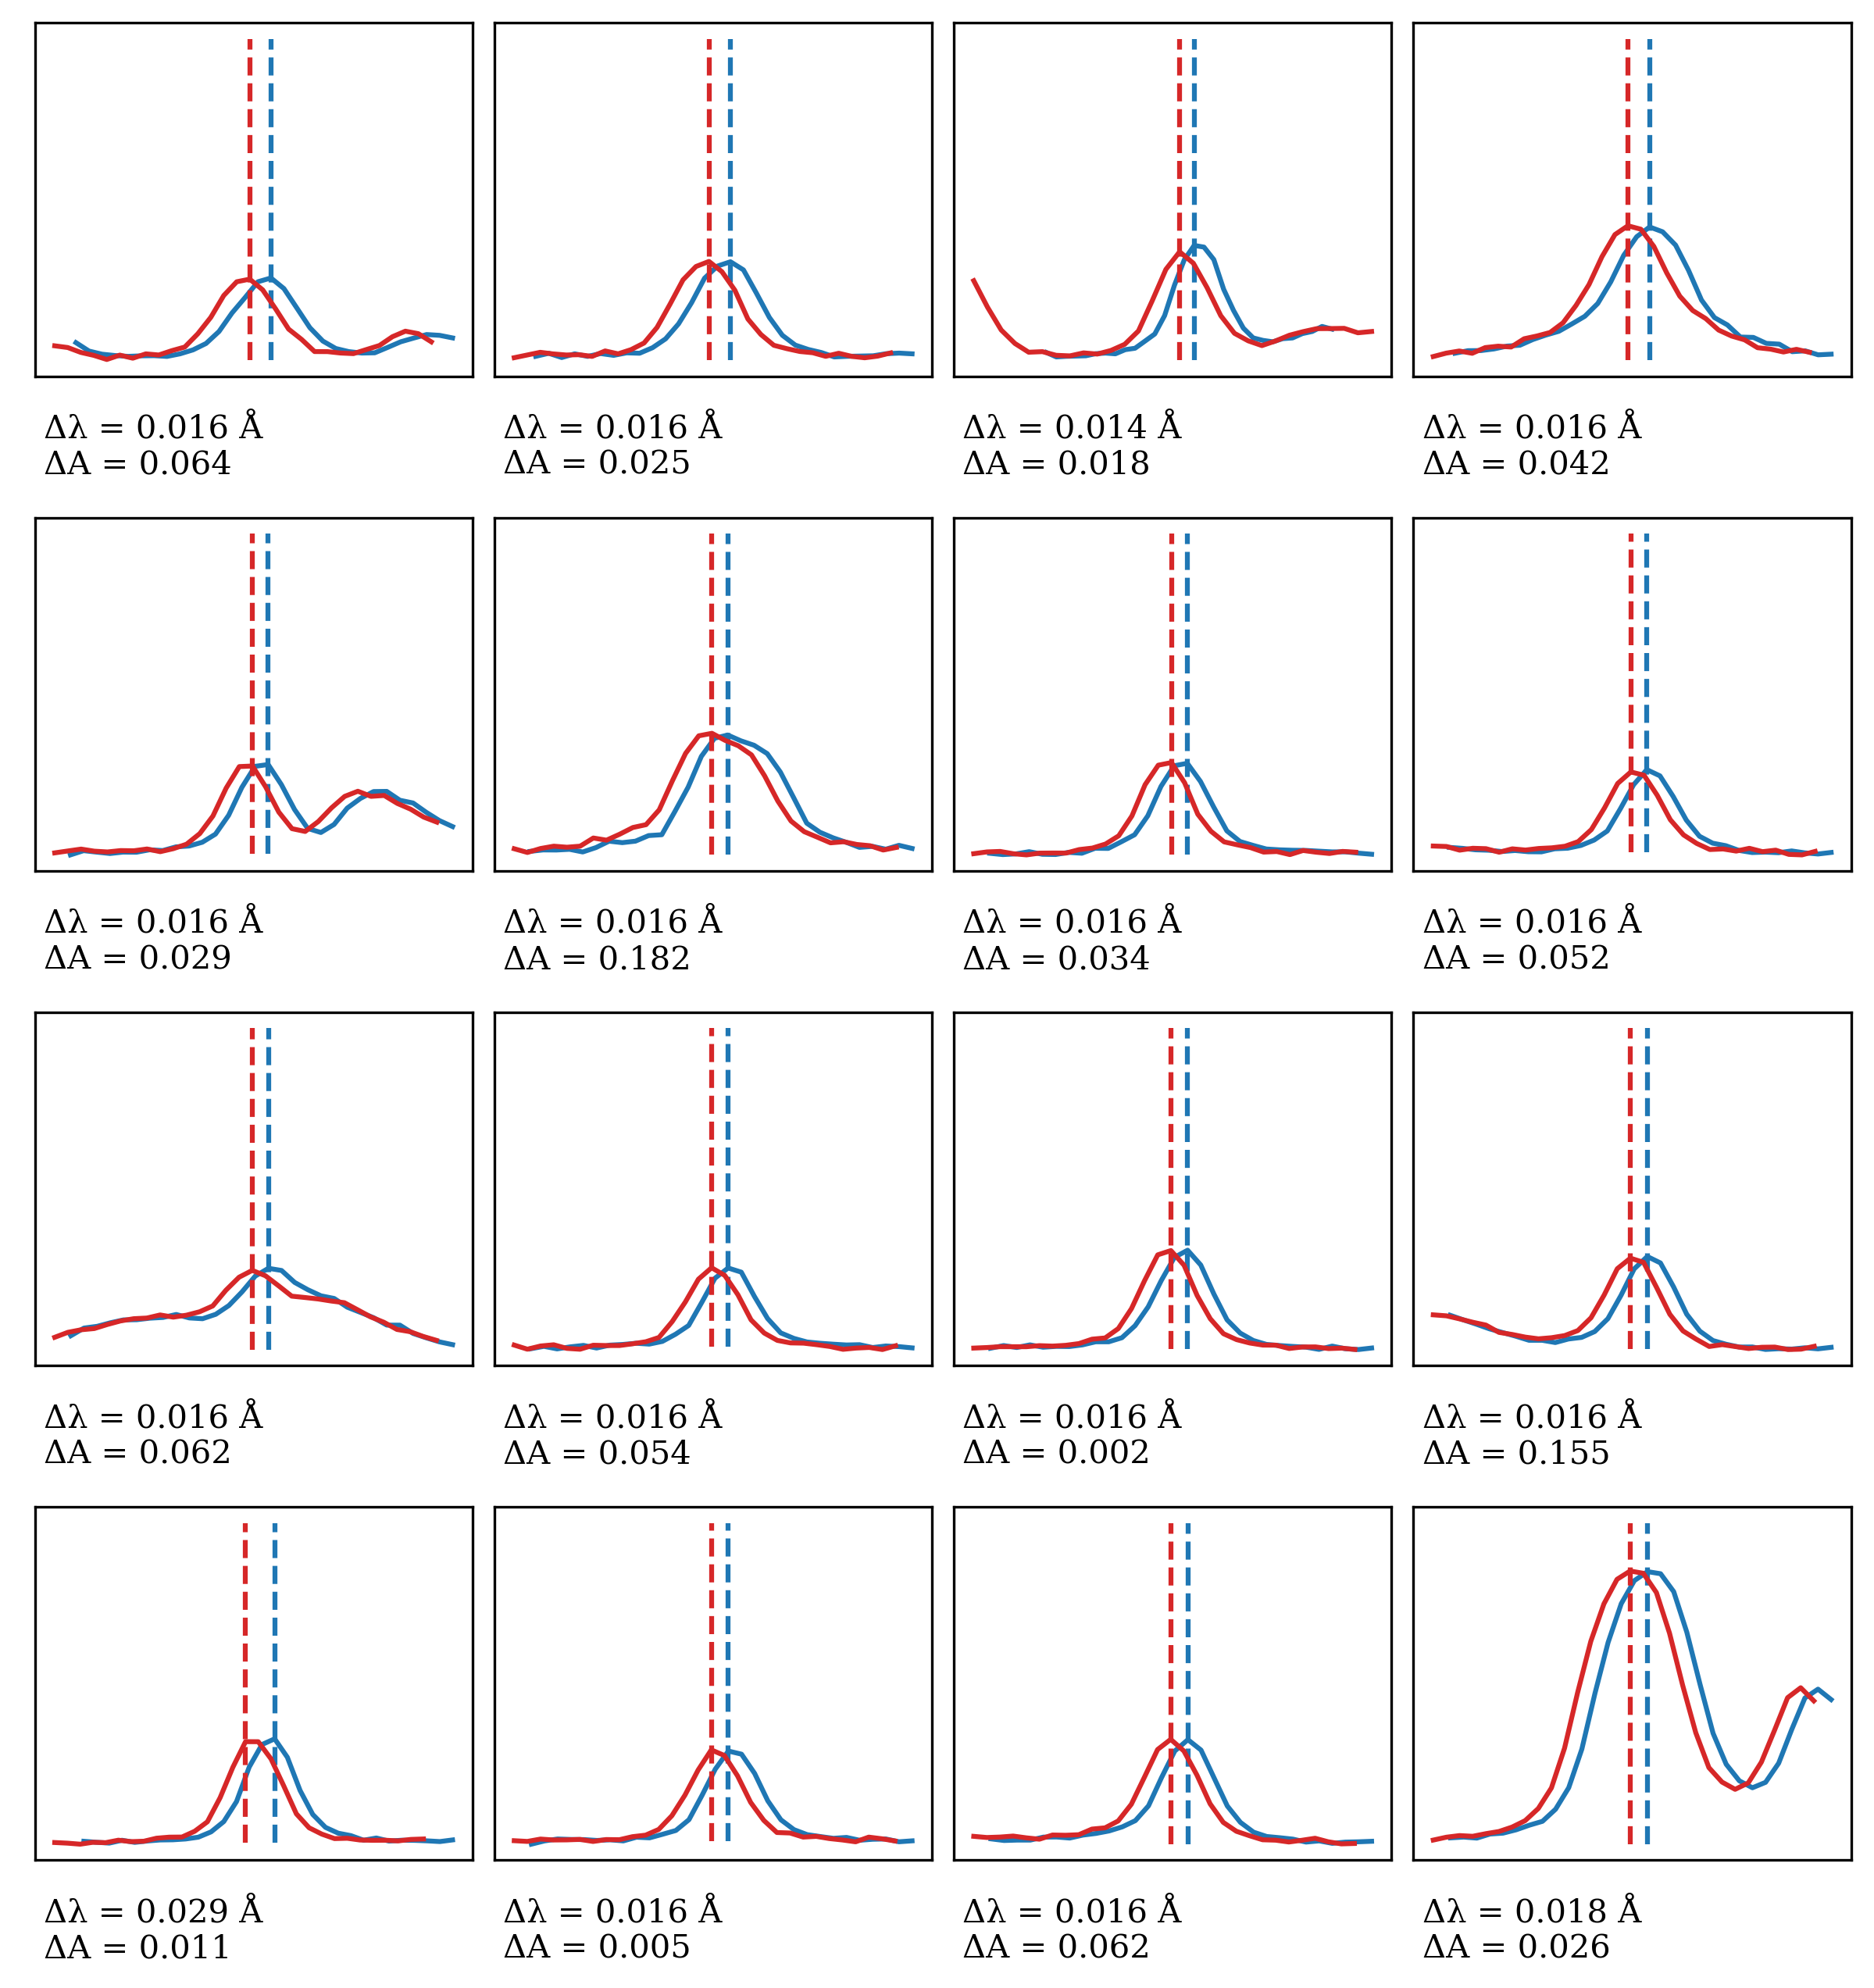

In [250]:
bad_matches = np.where(shifts[:,0] > 500)[0]
N_bad_matches = len(bad_matches)

plot_matches(matches[bad_matches][:20], ncols=4, nrows=4)